In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from math import ceil
from functools import partial
from pathlib import Path
import json
import concurrent.futures

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import xarray as xr
import cf_xarray as cfxr
import dask.array
import cftime
import scipy
import cmocean

from lmrecon.io import IntakeESMLoader, save_mfdataset, open_mfdataset
from lmrecon.plotting import plot_field, format_plot, save_plot, add_subplot_headers
from lmrecon.plotting_config import set_plotting_theme
from lmrecon.util import (
    stack_state,
    unstack_state,
    is_dask_array,
    get_data_path,
    to_math_order,
)
from lmrecon.logger import logging_disabled
from lmrecon.eof import EOF
from lmrecon.mapper import PhysicalSpaceForecastSpaceMapper, OMIT_FROM_SEPARATE_GLOBAL_MEAN
from lmrecon.lim import LIM
from lmrecon.da import create_initial_ensemble_from_sample, create_initial_ensemble_from_perturbations
from lmrecon.stats import area_weighted_mean, area_weighted_rmse, ce, compute_field_stds, average_annually
from lmrecon.time import month_name, Season
from lmrecon.scripts.train_lim import train_lim

set_plotting_theme()

In [ ]:
import dask
from distributed import Client

client = Client(n_workers=dask.system.CPU_COUNT // 2, threads_per_worker=1)

In [3]:
def load_lim(mapper_id):
    lim = train_lim(mapper_id)
    training_data_path = (get_data_path() / "mapper" / mapper_id)

    with (training_data_path / "metadata.json").open("r") as f:
        physical_dataset = Path(json.load(f)["physical_dataset"])
        print(physical_dataset)
    
    mapper = PhysicalSpaceForecastSpaceMapper.load(training_data_path / "mapper.pkl")
    data_lim_training = open_mfdataset(training_data_path / f"seasonal_anomalies")["data"]
    ds_ver = xr.open_zarr(get_data_path() / physical_dataset)

    return lim, mapper, data_lim_training, ds_ver

In [4]:
# mapper_id = "2025-04-04T17-47-00"  # MPI
# mapper_id = "2025-04-04T17-51-21"  # CESM
mapper_id = "2025-04-05T14-48-31"  # MRI
lim, mapper, data_lim_training, ds_ver = load_lim(mapper_id)

2025-09-03 12:19:39    INFO Training LIM on 2025-04-05T14-48-31 (3999 samples, state size 130)
2025-09-03 12:19:40    INFO Found 13 modes with negative eigenvalues in the noise covariance Q, removing them and rescaling 117 remaining eigenvalues of Q
2025-09-03 12:19:40    INFO Q eigenvalue rescaling: 0.82


cmip6/MRI-ESM2-0/past1000/seasonal_anomalies_detrended.zarr


In [5]:
plot_folder = get_data_path() / "mapper" / mapper_id / "plots"

# LIM matrices

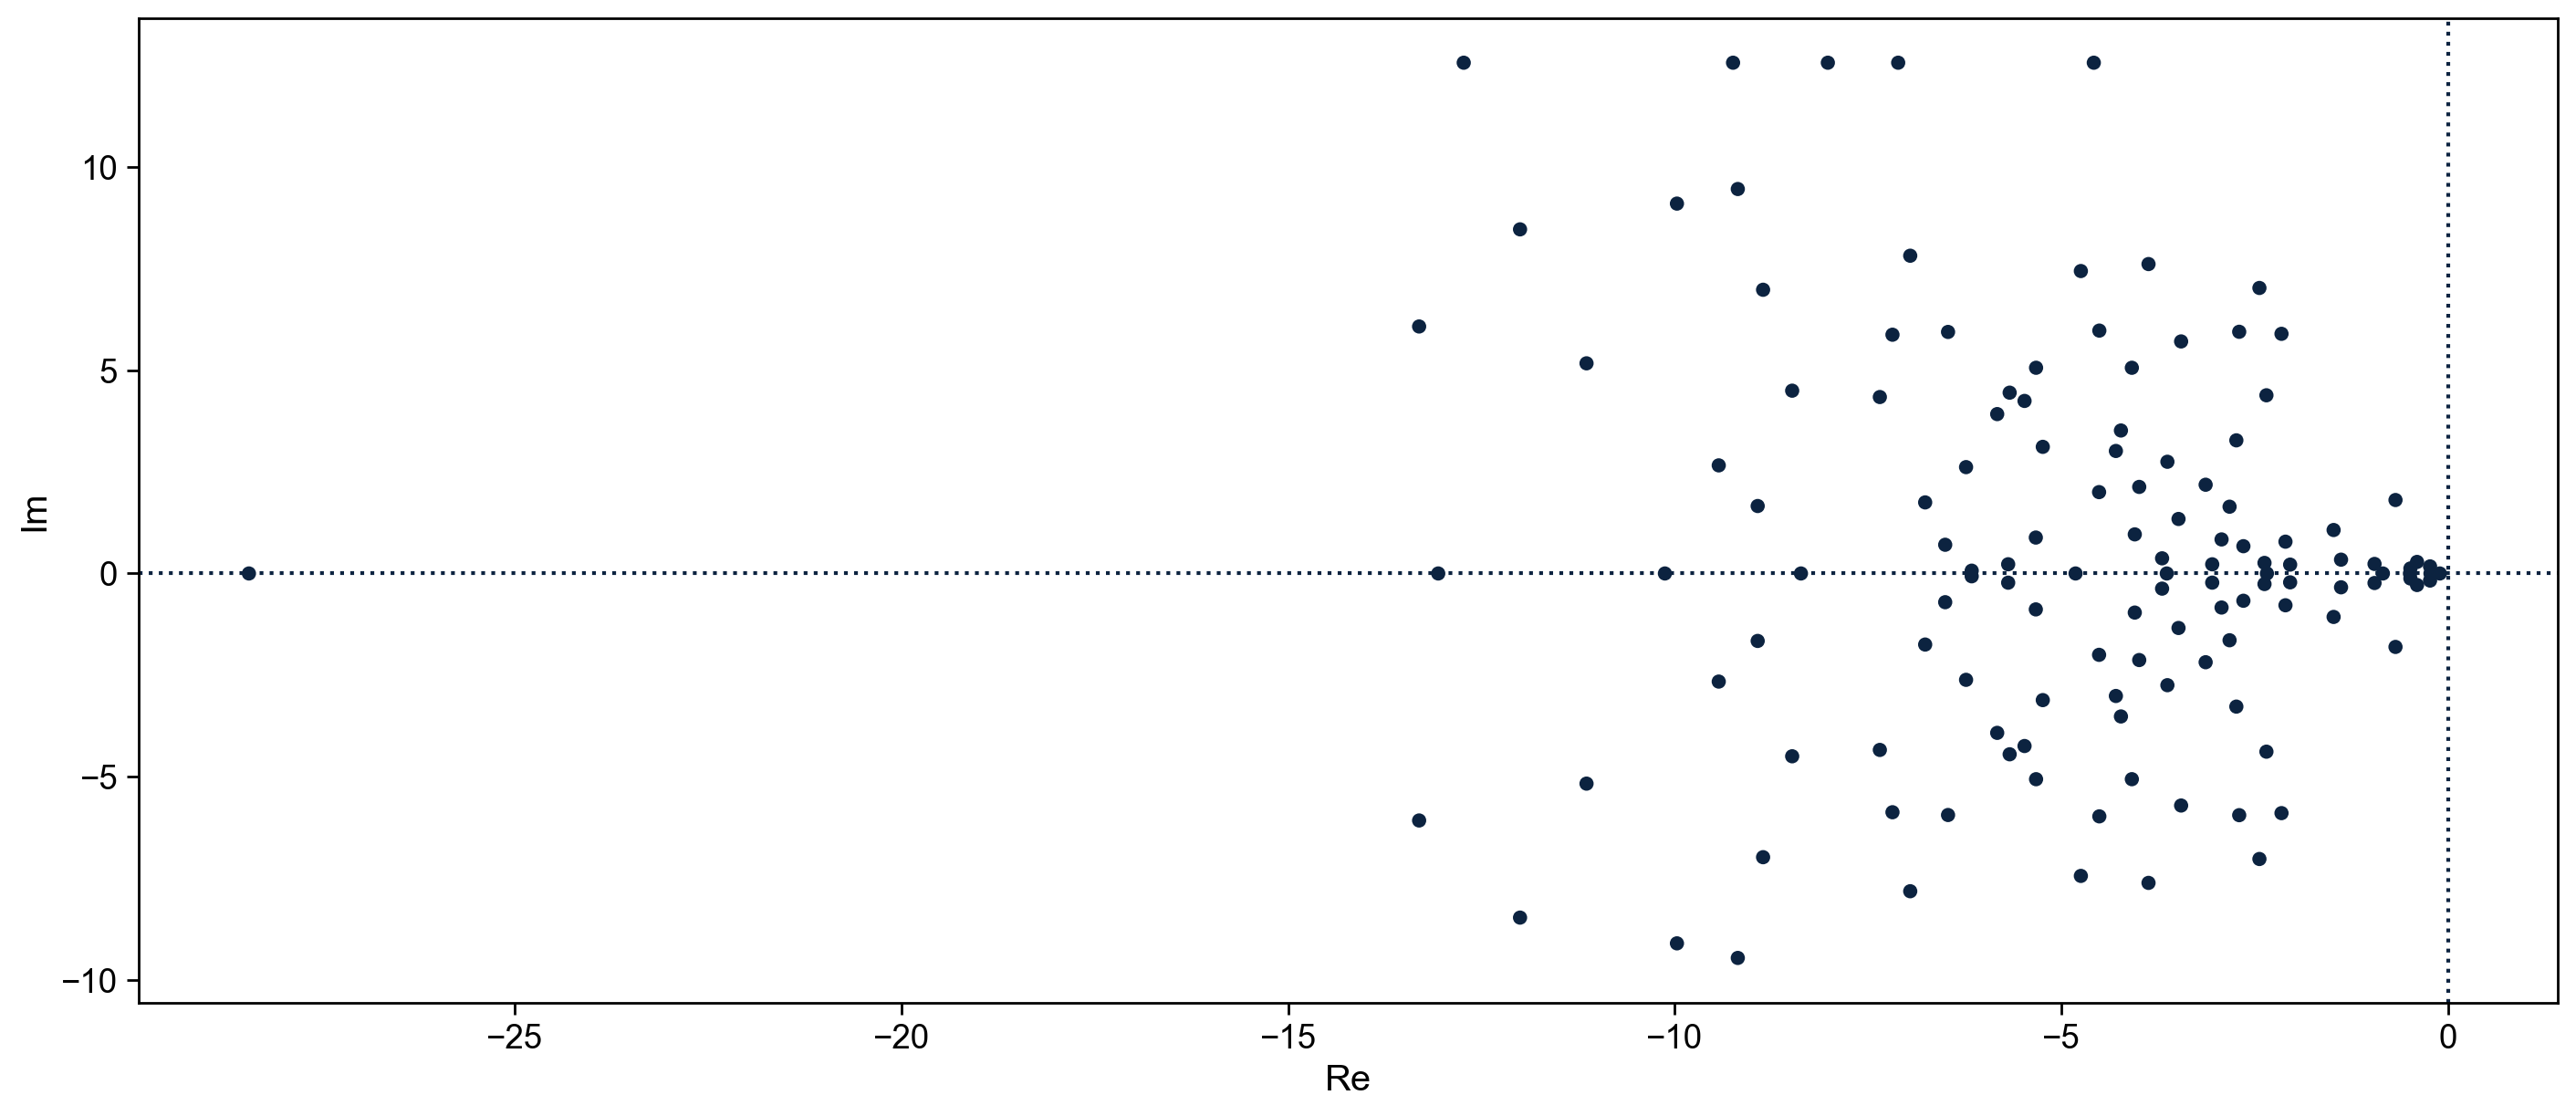

In [10]:
def plot_eigenvalues():
    fig, ax = plt.subplots()

    eigs = np.linalg.eigvals(lim.L)
    ax.axvline(0, ls=":")
    ax.axhline(0, ls=":")
    ax.scatter(np.real(eigs), np.imag(eigs), c=np.where(np.real(eigs) < 0, "C0", "C1"))
    ax.set_xlabel("Re")
    ax.set_ylabel("Im")
    # ax.set_aspect("equal")

    format_plot()
    save_plot(plot_folder, "eigenvalues")

plot_eigenvalues()

Lower time constant -> faster response

Fastest mode: tau = 0.02 years
Slowest mode: tau = 1.10 years


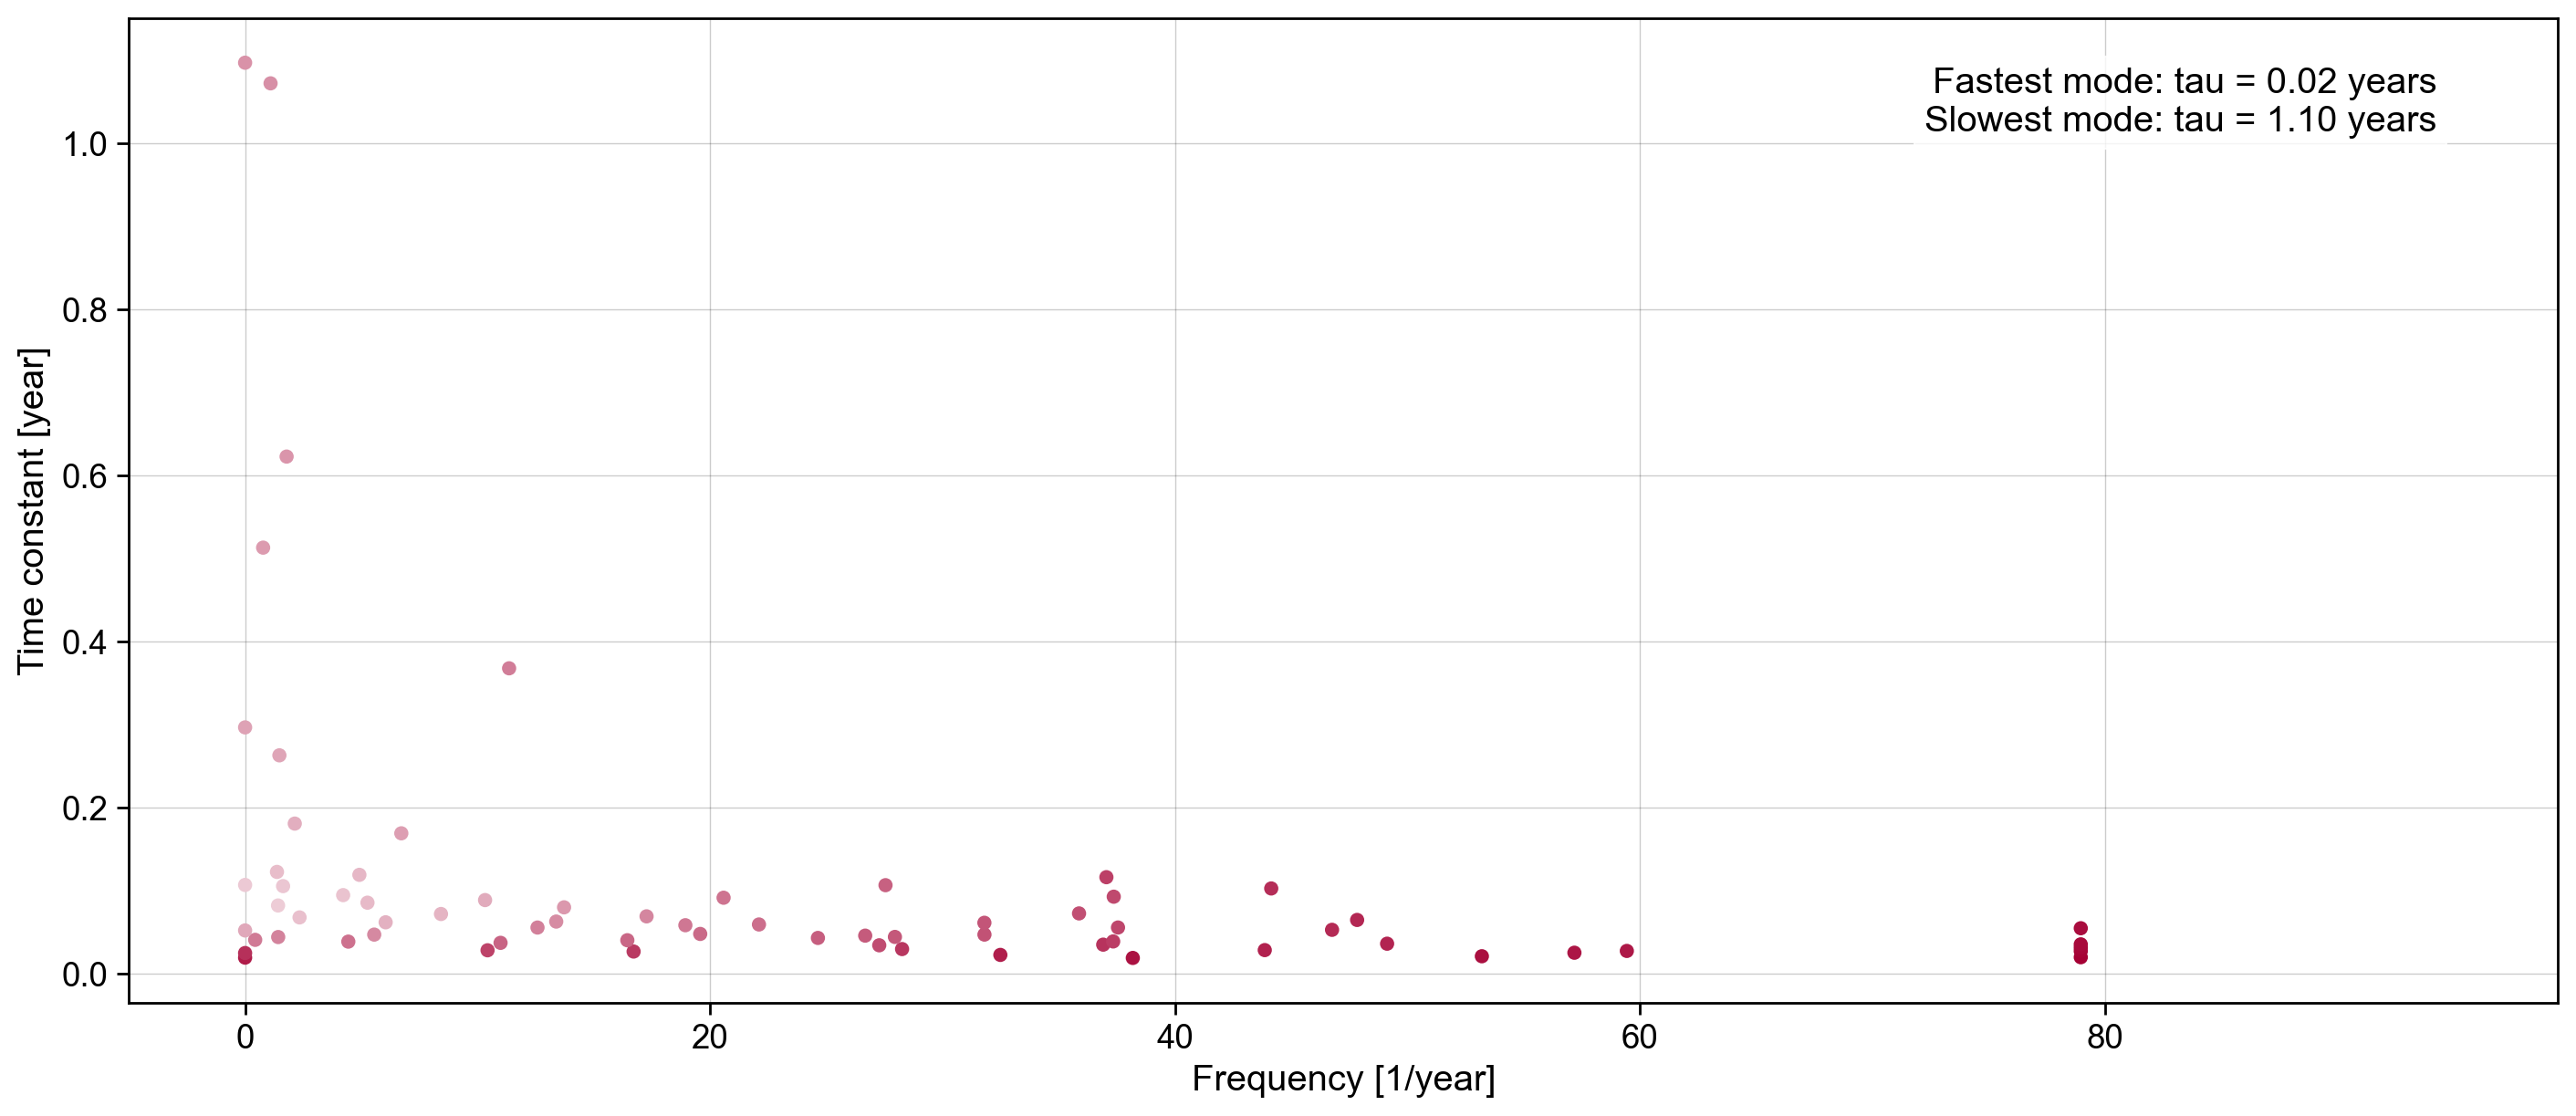

In [ ]:
def plot_frequency_spectrum():
    fig, ax = plt.subplots()

    eigs = np.linalg.eigvals(lim.L)
    eigs = eigs[np.imag(eigs) >= 0]
    fs = np.imag(eigs) / 2 * np.pi
    taus = -1 / np.real(eigs)

    # Adjust for frequency
    taus *= lim.tau
    fs /= lim.tau

    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "cmap",
        [
            mpl.colors.to_rgb("white"),
            mpl.colors.to_rgb("C1"),
        ],
    )(np.linspace(1, 0.2, len(eigs)))
    
    ax.scatter(fs, taus, color=cmap)
    ax.set_xlabel("Frequency [1/year]")
    ax.set_ylabel("Time constant [year]")
    ax.set_xlim([-5, ax.get_xlim()[1] * 1.2])
    # ax.set_xscale("log")

    print(f"Fastest mode: tau = {np.min(taus):.2f} years")
    print(f"Slowest mode: tau = {np.max(taus):.2f} years")
    ax.text(0.95, 0.95, f"Fastest mode: tau = {np.min(taus):.2f} years\nSlowest mode: tau = {np.max(taus):.2f} years",
            transform=ax.transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8))
    

    # secax = ax.secondary_xaxis("top", functions=(lambda x: 1 / x, lambda x: 1 / x))
    # secax.set_xlabel("Period [year]")

    # ax_hist = fig.add_subplot(111, label="2", frame_on=False)
    # ax_hist.set_axis_off()
    # ax_hist.hist(taus, 30, orientation="horizontal", density=True)
    # ax_hist.set_xlim([3, 0])in

    format_plot(major_grid=True)
    save_plot(plot_folder, "freq_spectrum")


plot_frequency_spectrum()

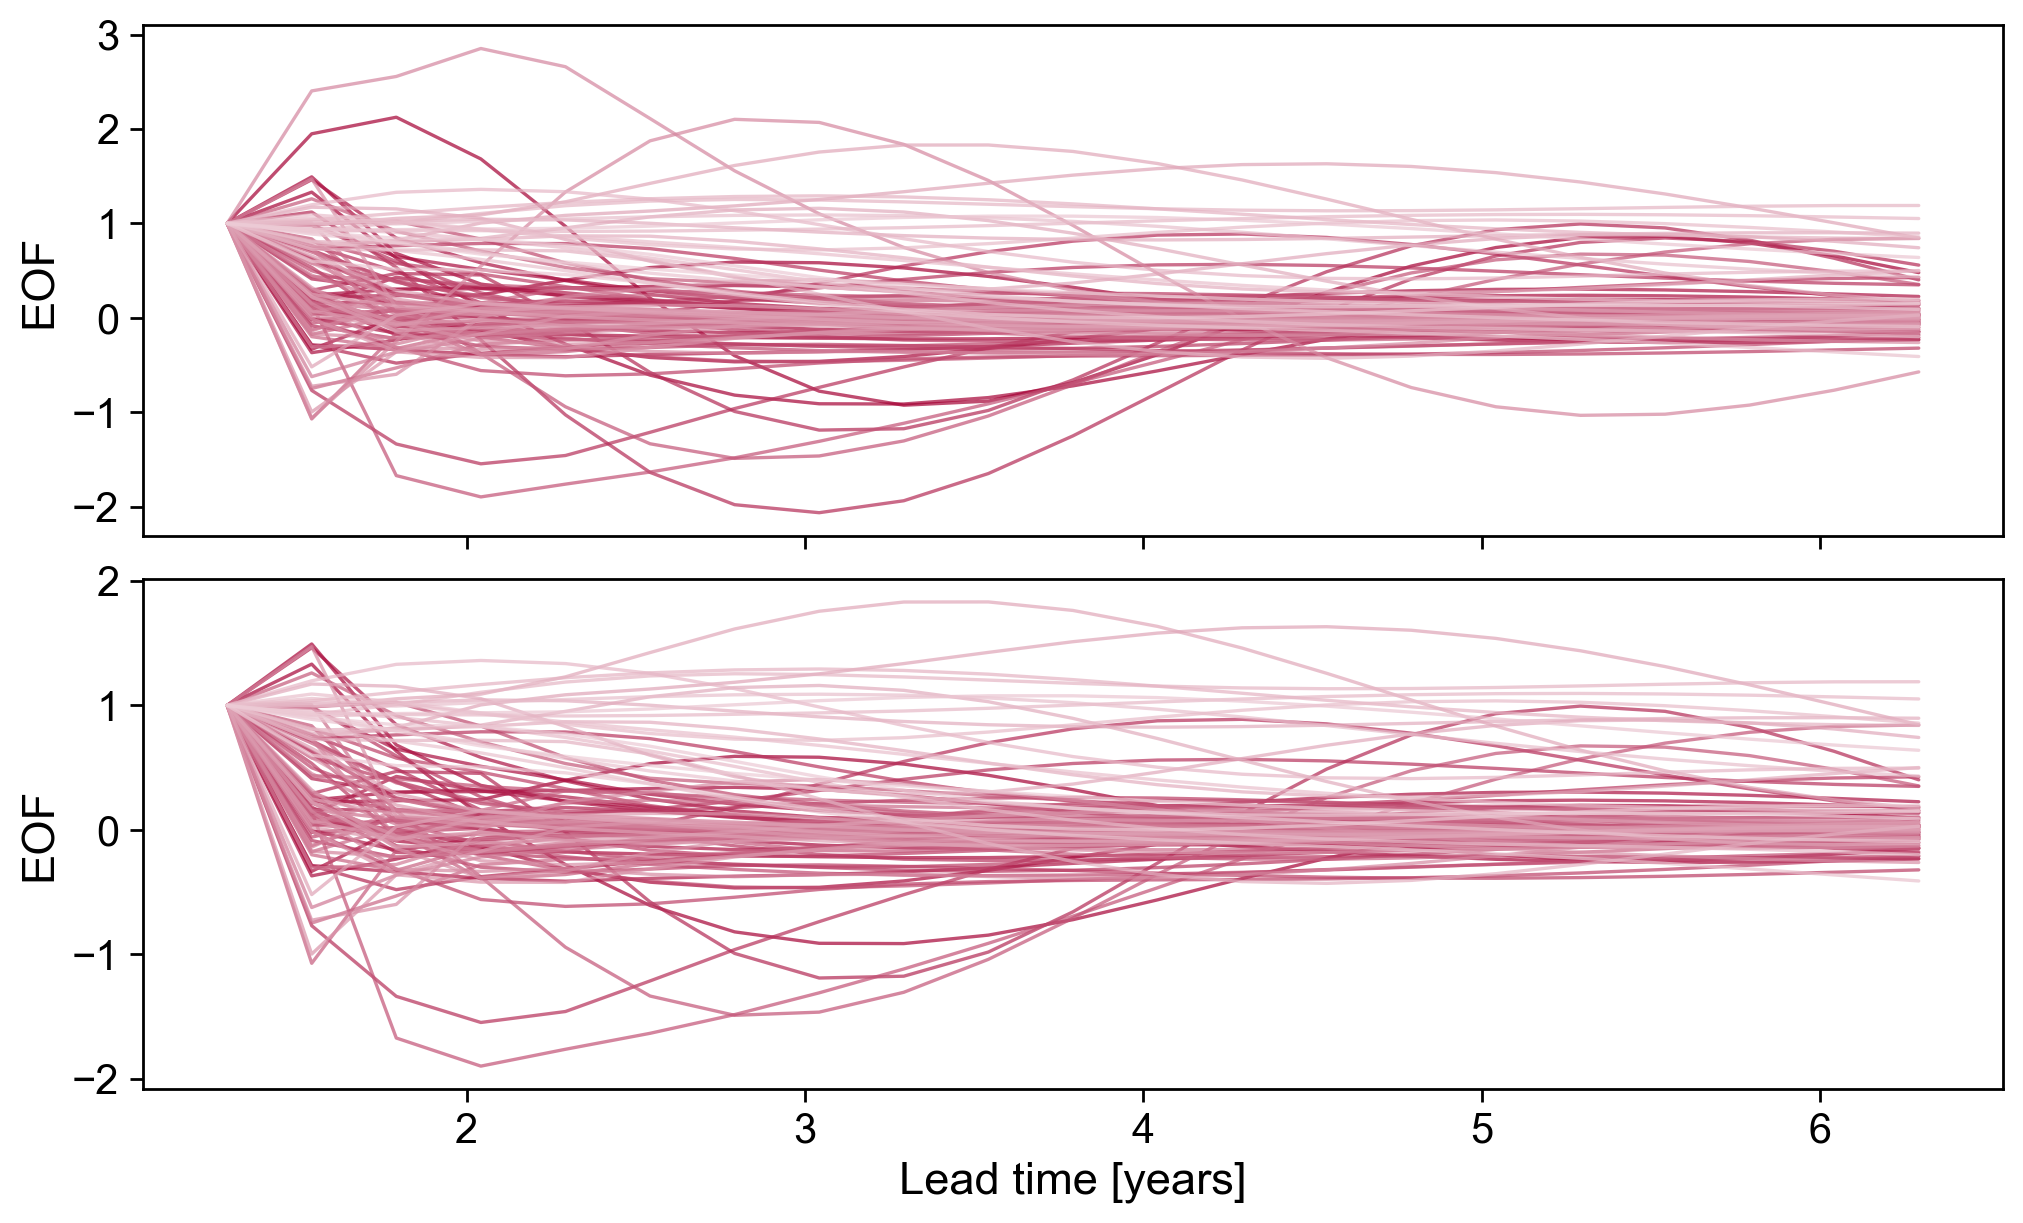

In [ ]:
def plot_forecast_eof(n_steps=15):
    ones = xr.DataArray(
        dask.array.ones((len(data_lim_training.state), 1)), coords=dict(state=data_lim_training.state, time=data_lim_training.isel(time=0).time)
    )
    fc_eof = lim.forecast_deterministic(ones, n_steps)
    # fc_eof = lim.forecast(data_lim_training.isel(time=0), n_steps)

    fig, axs = plt.subplots(2, sharex=True, figsize=(10, 6))

    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "cmap",
        [
            mpl.colors.to_rgb("white"),
            mpl.colors.to_rgb("C1"),
        ],
    )(np.linspace(1, 0.2, len(fc_eof.state)))

    for state, color in zip(fc_eof.state, cmap):
        y = fc_eof.isel(state=state)
        axs[0].plot(y.time, y, color=color, alpha=0.7)
        if np.max(np.abs(y)) < 2:
            axs[1].plot(y.time, y, color=color, alpha=0.7)

    axs[1].set_xlabel("Lead time [years]")
    axs[0].set_ylabel("EOF")
    axs[1].set_ylabel("EOF")
    # axs[1].set_ylim([-3, 3])

    format_plot()


plot_forecast_eof(20)

100%|██████████| 5401/5401 [00:03<00:00, 1450.44step/s]


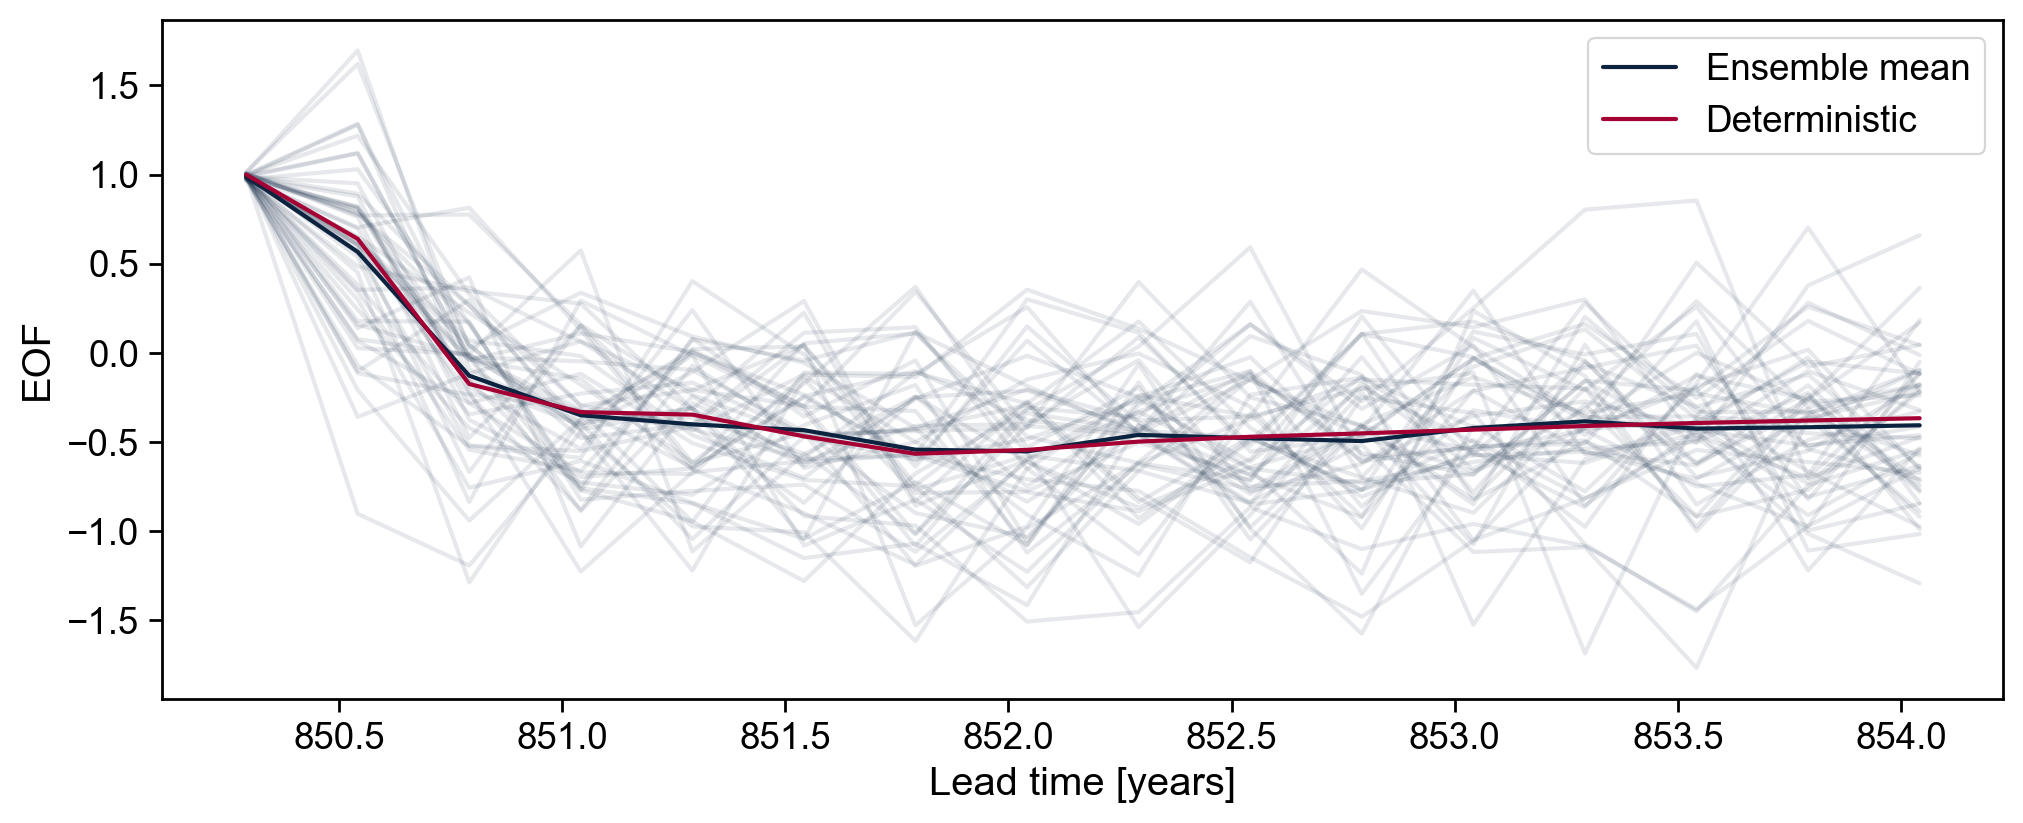

In [19]:
def plot_forecast_stochastic_ones(n_steps=15, n_ensemble=100, eof=0):
    ones = to_math_order(
        xr.DataArray(
            dask.array.ones((len(data_lim_training.state), n_ensemble)),
            dims=["state", "ens"],
            coords=dict(state=data_lim_training.state, ens=range(n_ensemble), time=data_lim_training.isel(time=0).time),
        )
    )
    fc_eof = lim.forecast_stochastic(ones, n_steps, int(1440 * lim.tau)).isel(state=eof)
    fc_eof_det = lim.forecast_deterministic(ones[:, 0], n_steps).isel(state=eof)

    fig, ax = plt.subplots(sharex=True, figsize=(10, 4))

    for i in range(n_ensemble):
        ax.plot(fc_eof.time, fc_eof.isel(ens=i), color="C0", alpha=0.1)

    ax.plot(fc_eof.time, fc_eof.mean("ens"), label="Ensemble mean")
    ax.plot(fc_eof_det.time, fc_eof_det, label="Deterministic")

    ax.set_xlabel("Lead time [years]")
    ax.set_ylabel("EOF")
    # axs[1].set_ylim([-3, 3])
    ax.legend()

    format_plot()


plot_forecast_stochastic_ones(n_steps=15, n_ensemble=50, eof=0)

  9%|▊         | 1889/21601 [00:01<00:11, 1779.48step/s]

100%|██████████| 21601/21601 [00:10<00:00, 2150.96step/s]


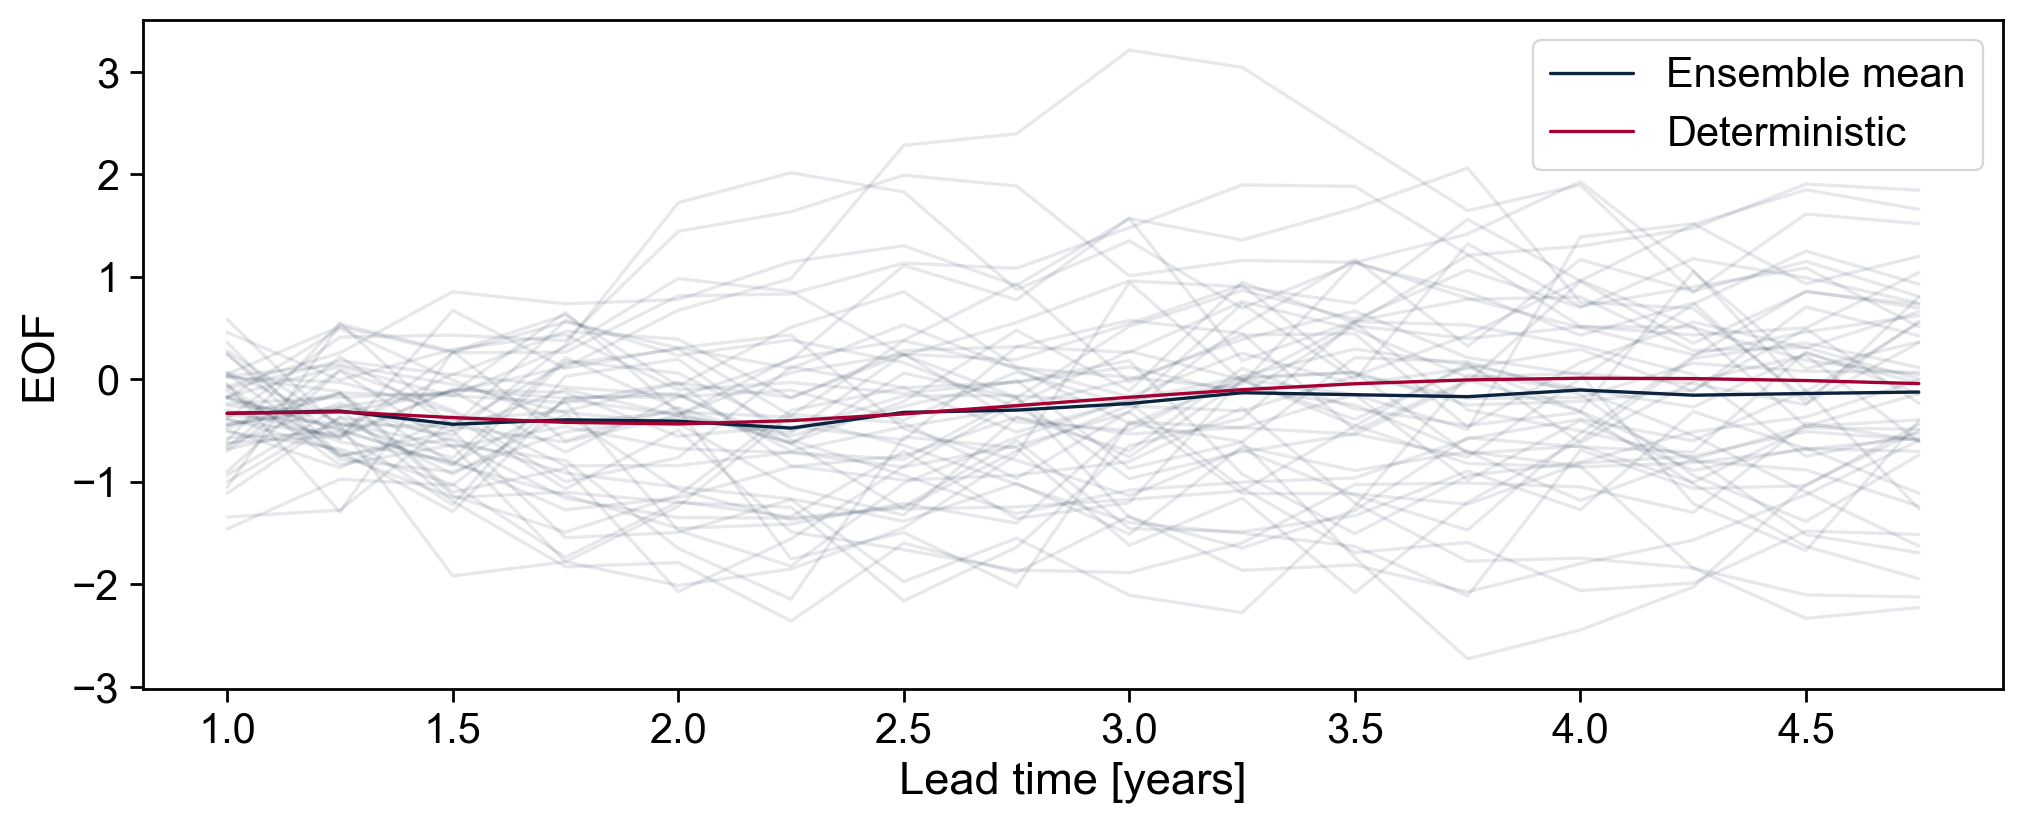

In [ ]:
def plot_forecast_stochastic(n_steps=15, n_ensemble=100, eof=0):
    # initial_ensemble = to_math_order(create_initial_ensemble_from_sample(data_lim_training, n_ensemble, 0))
    initial_ensemble = to_math_order(create_initial_ensemble_from_perturbations(data_lim_training.isel(time=0), n_ensemble, year_start=1, std=1))

    fc_eof = lim.forecast_stochastic(initial_ensemble, n_steps, 1440).isel(state=eof)
    fc_eof_det = lim.forecast_deterministic(initial_ensemble.mean("ens"), n_steps).isel(state=eof)

    fig, ax = plt.subplots(sharex=True, figsize=(10, 4))

    for i in range(n_ensemble):
        ax.plot(fc_eof.time, fc_eof.isel(ens=i), color="C0", alpha=0.1)

    ax.plot(fc_eof.time, fc_eof.mean("ens"), label="Ensemble mean")
    ax.plot(fc_eof_det.time, fc_eof_det, label="Deterministic")

    ax.set_xlabel("Lead time [years]")
    ax.set_ylabel("EOF")
    # axs[1].set_ylim([-3, 3])
    ax.legend()

    format_plot()


plot_forecast_stochastic(n_steps=15, n_ensemble=50, eof=0)

Ensemble initialized using "create_initial_ensemble_from_sample" has zero mean from beginning. This makes sense because sample is drawn from dataset with respect to which anomalies were calculated.

tas: 0-21
tos: 21-42
eei: 42-73
rsut: 73-89
rlut: 89-100
ohc700: 100-121
siconc: 121-136


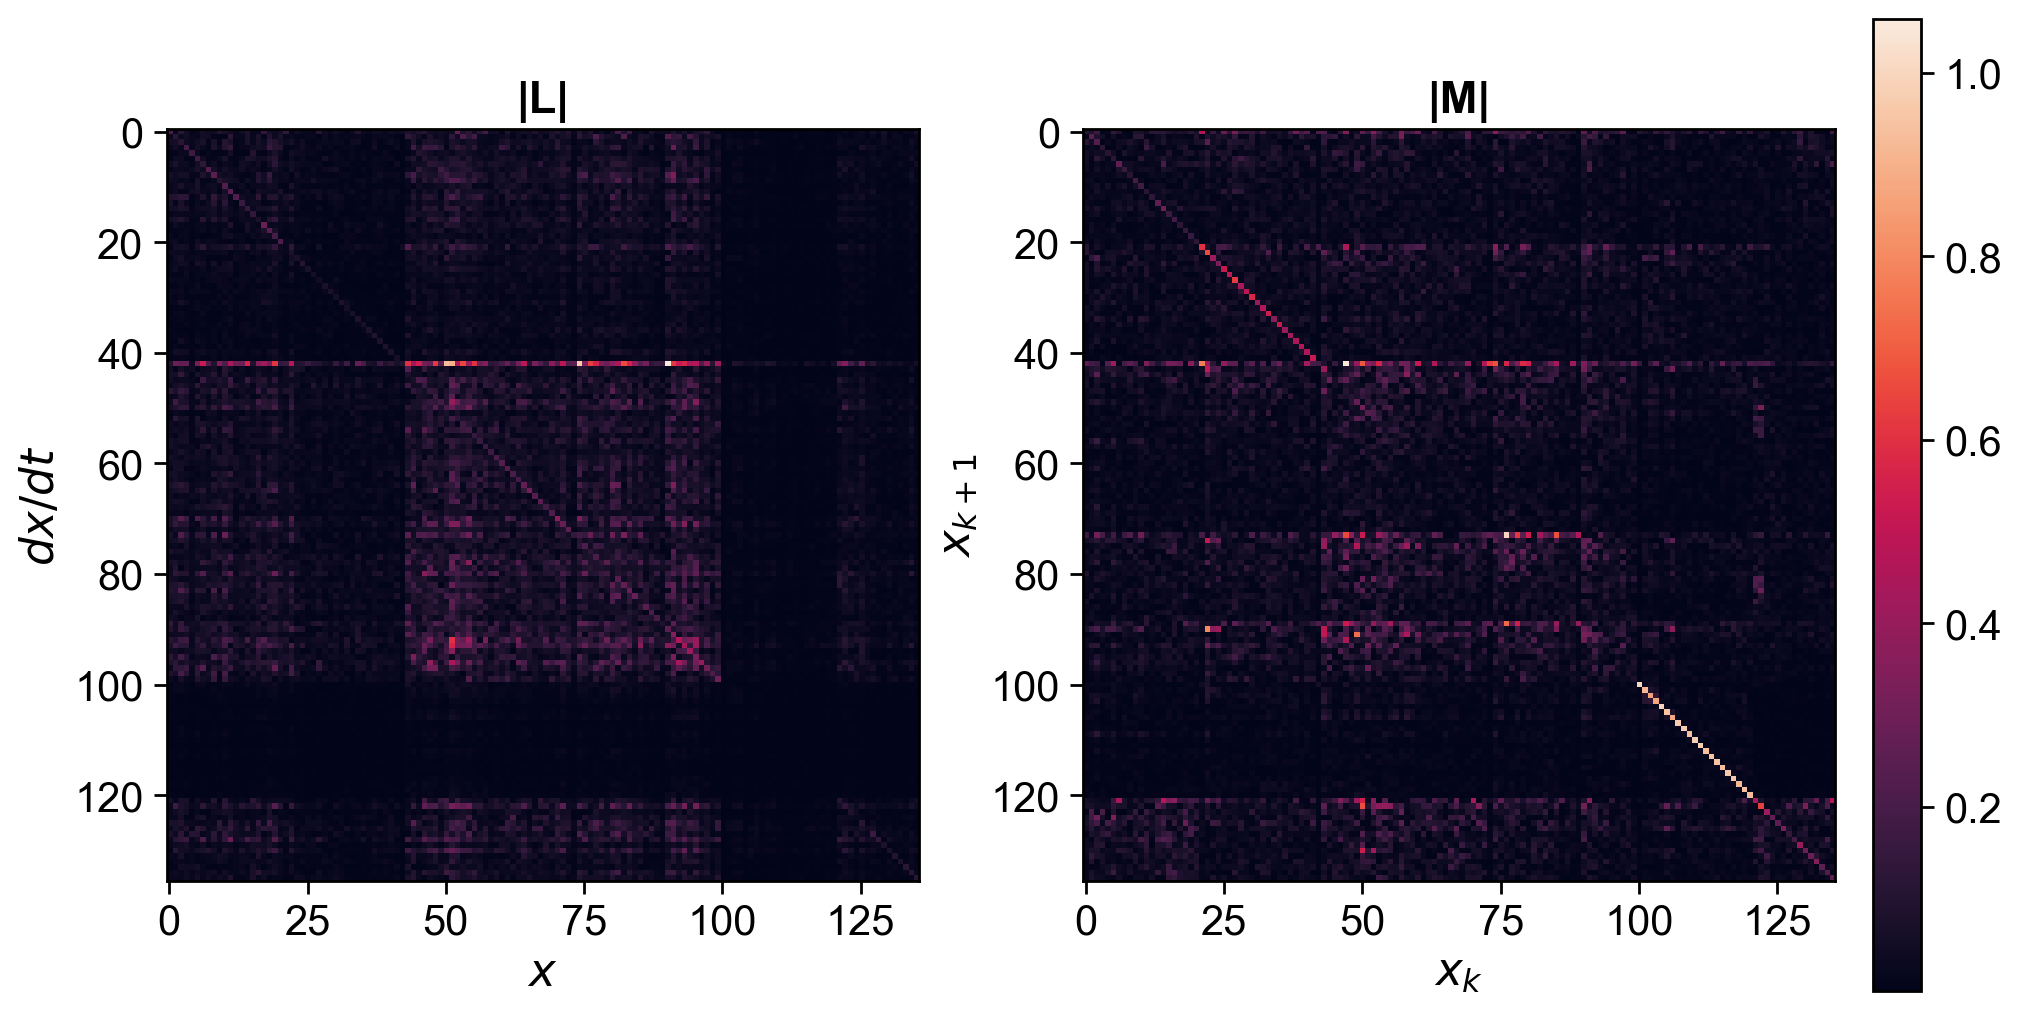

In [ ]:
def plot_matrix_values(log=False):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    if log:
        tf = lambda x: np.log(np.abs(x))
        prefix = "log "
    else:
        tf = lambda x: np.abs(x)
        prefix = ""

    L = tf(lim.L)
    L /= L.max()
    M = tf(lim.G_tau)
    M /= M.max()

    ax = axs[0]
    ax.imshow(tf(lim.L))
    ax.set_title(prefix + "|L|")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$dx/dt$")
    ax.tick_params(direction="out")

    ax = axs[1]
    im = ax.imshow(tf(lim.G_tau))
    ax.set_title(prefix + "|M|")
    ax.set_xlabel("$x_k$")
    ax.set_ylabel("$x_{k+1}$")
    ax.tick_params(direction="out")
    plt.colorbar(im)

    # Assuming only individual modes
    idx = 0
    for f in mapper.k_direct:
        length = mapper.k_direct[f]
        if mapper.separate_global_mean and f not in OMIT_FROM_SEPARATE_GLOBAL_MEAN:
            length += 1
        print(f"{f}: {idx}-{idx + length}")
        idx += length
    assert idx == mapper.n_reduced_state

    format_plot()
    if not log:
        save_plot(plot_folder, "matrix_values")

plot_matrix_values()

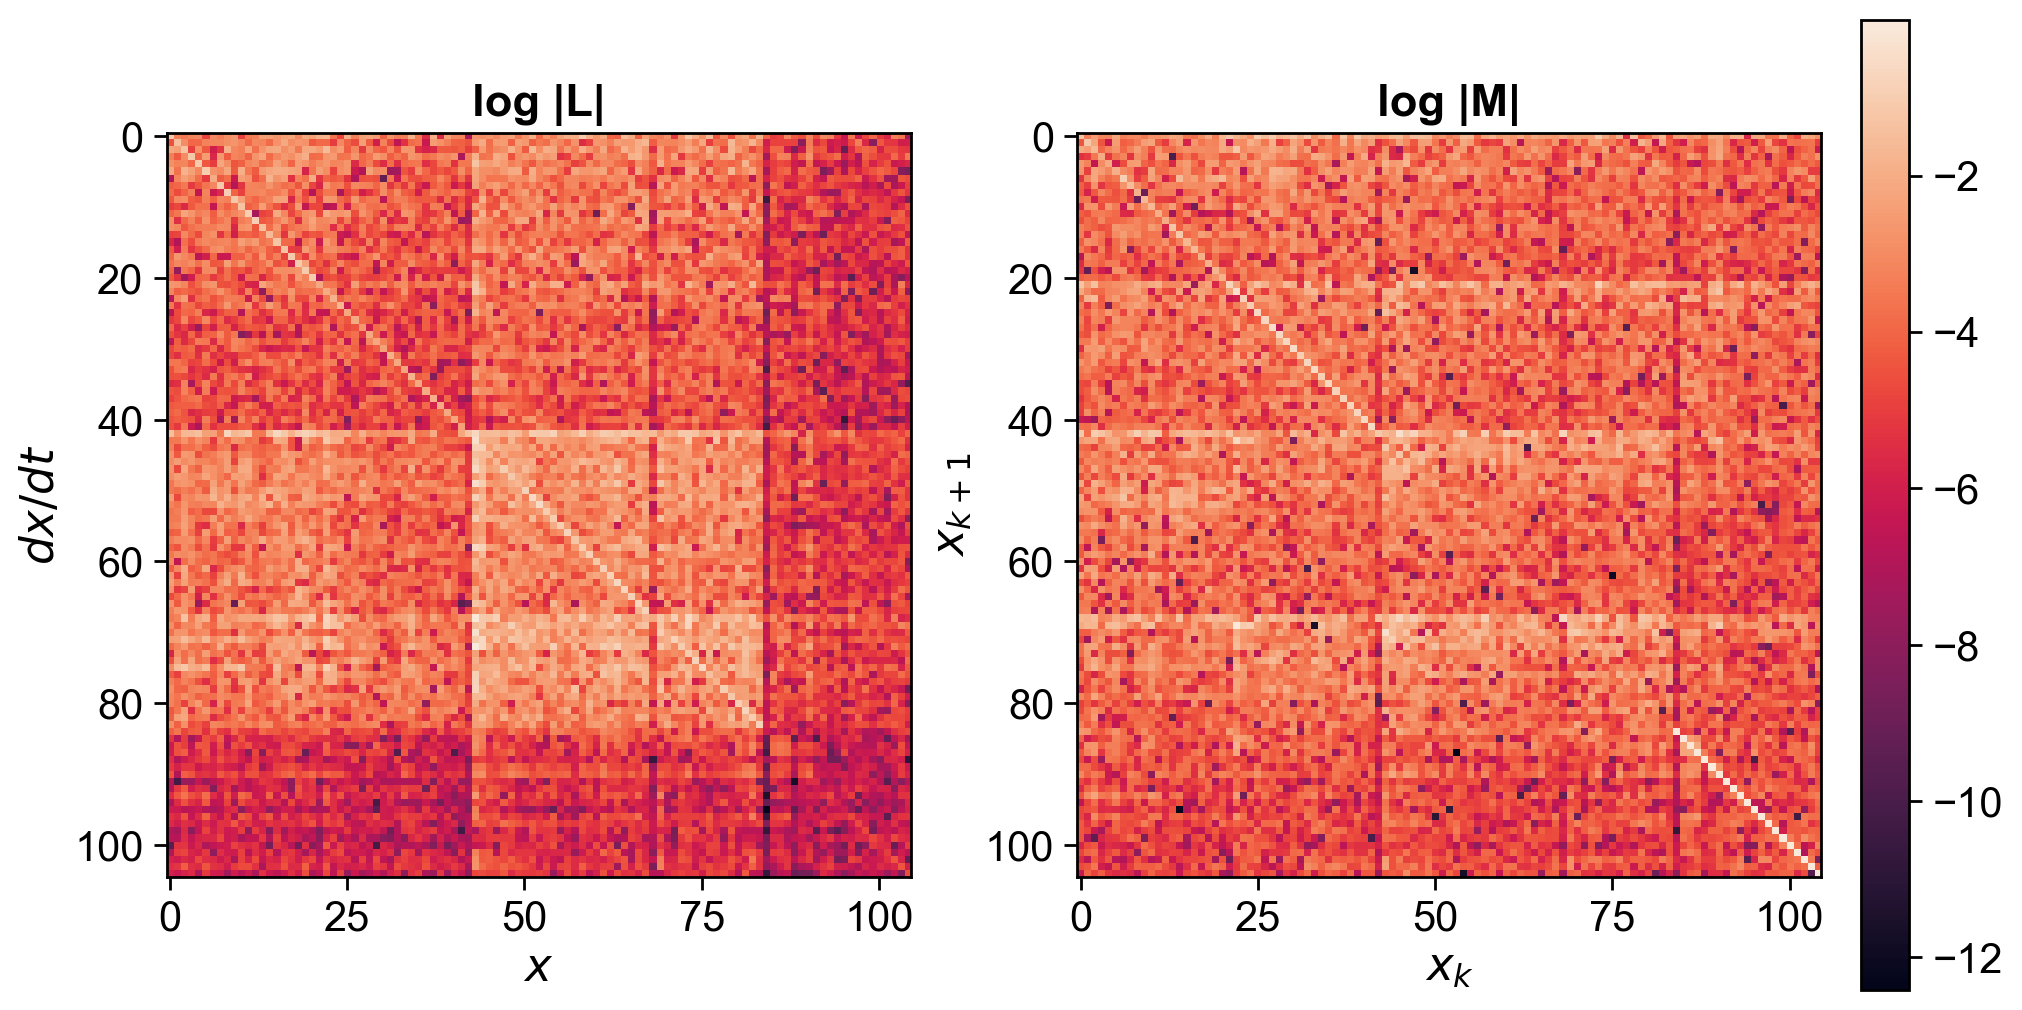

In [ ]:
plot_matrix_values(log=True)

# Forecast verification

In [ ]:
fcs = xr.open_mfdataset((get_data_path() / "lim" / lim_id / "verification").glob("forecast-*.nc"))
trues = xr.open_mfdataset([p for p in (get_data_path() / "lim" / lim_id / "verification").glob("verification-*.nc") if "trunc" not in str(p)])
trues_trunc = xr.open_mfdataset((get_data_path() / "lim" / lim_id / "verification").glob("verification-trunc-*.nc"))

In [ ]:
fcs_mean = fcs.mean("ens").compute()

In [ ]:
def calculate_forecast_metrics(fcs, trues, fields=["tas", "rsut", "rlut"]):
    fcs = fcs[fields]
    trues = trues[fields]

    import dask.distributed
    with dask.distributed.Client(n_workers=dask.system.CPU_COUNT // 2, threads_per_worker=1):
        corr = unstack_state(xr.corr(stack_state(fcs), stack_state(trues), dim=["case"]))
        ce_ = unstack_state(ce(stack_state(fcs), stack_state(trues), dim=["case"]))
        return corr.compute(), ce_.compute()

corr, ce_full = calculate_forecast_metrics(fcs.mean("ens"), trues)
corr_trunc, ce_trunc = calculate_forecast_metrics(fcs.mean("ens"), trues_trunc)

2025-01-01 09:16:00    INFO To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-01-01 09:16:00    INFO State start
2025-01-01 09:16:00    INFO   Scheduler at:     tcp://127.0.0.1:38699
2025-01-01 09:16:00    INFO   dashboard at:  http://127.0.0.1:8787/status
2025-01-01 09:16:00    INFO Registering Worker plugin shuffle
2025-01-01 09:16:00    INFO         Start Nanny at: 'tcp://127.0.0.1:38675'
2025-01-01 09:16:00    INFO         Start Nanny at: 'tcp://127.0.0.1:37421'
2025-01-01 09:16:00    INFO         Start Nanny at: 'tcp://127.0.0.1:38901'
2025-01-01 09:16:00    INFO         Start Nanny at: 'tcp://127.0.0.1:40871'
2025-01-01 09:16:04    INFO Register worker addr: tcp://127.0.0.1:46219 name: 1
2025-01-01 09:16:04    INFO Starting worker compute stream, tcp://127.0.0.1:46219
2025-01-01 09:16:04    INFO Starting established connection to tcp://127.0.0.1:34124
2025-01-01 09:16:04    INFO Register worker addr: tc

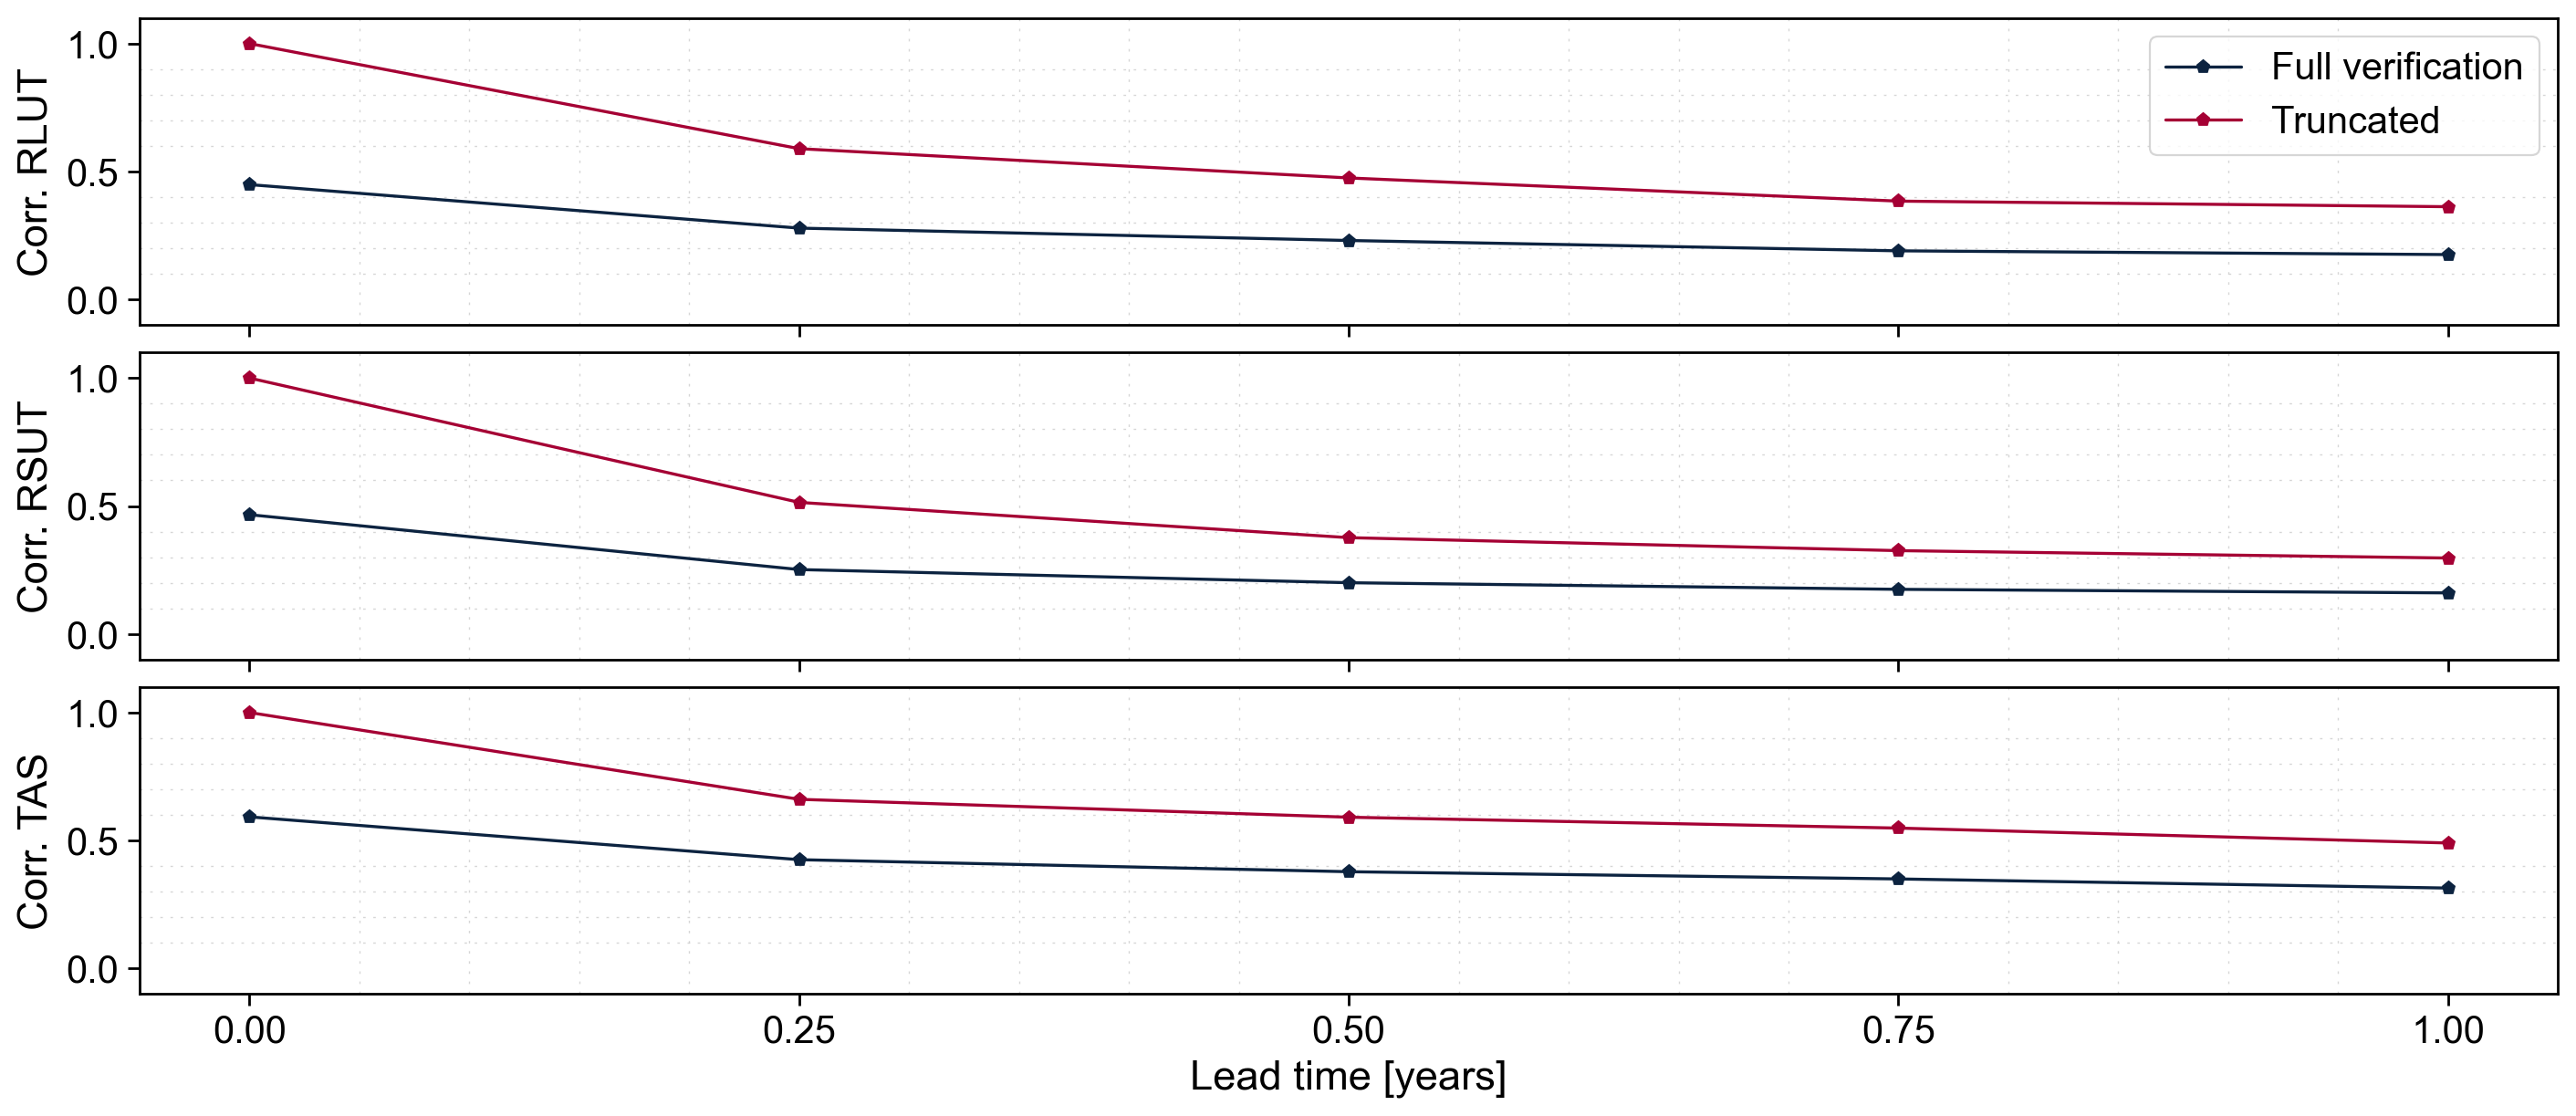

In [ ]:
def plot_forecast_corr_evolution():
    fields = list(corr.keys())
    fig, axs = plt.subplots(len(fields), figsize=(14, len(fields) * 2), sharex=True)

    for ax, field in zip(axs, fields):
        ax.plot(corr.time, area_weighted_mean(corr[field]), "-p", c="C0", label="Full verification")
        ax.plot(corr_trunc.time, area_weighted_mean(corr_trunc[field]), "-p", c="C1", label="Truncated")

    axs[0].legend()
    axs[-1].set_xlabel("Lead time [years]")
    for ax, field in zip(axs, fields):
        ax.set_ylabel(f"Corr. {field.upper()}")
        ax.set_ylim([-0.1, 1.1])

    format_plot(minor_grid=True, y_minor_locator=mpl.ticker.AutoMinorLocator())
    axs[0].set_xticks(corr.time)
    save_plot(plot_folder, "forecast_corr_evolution")

plot_forecast_corr_evolution()

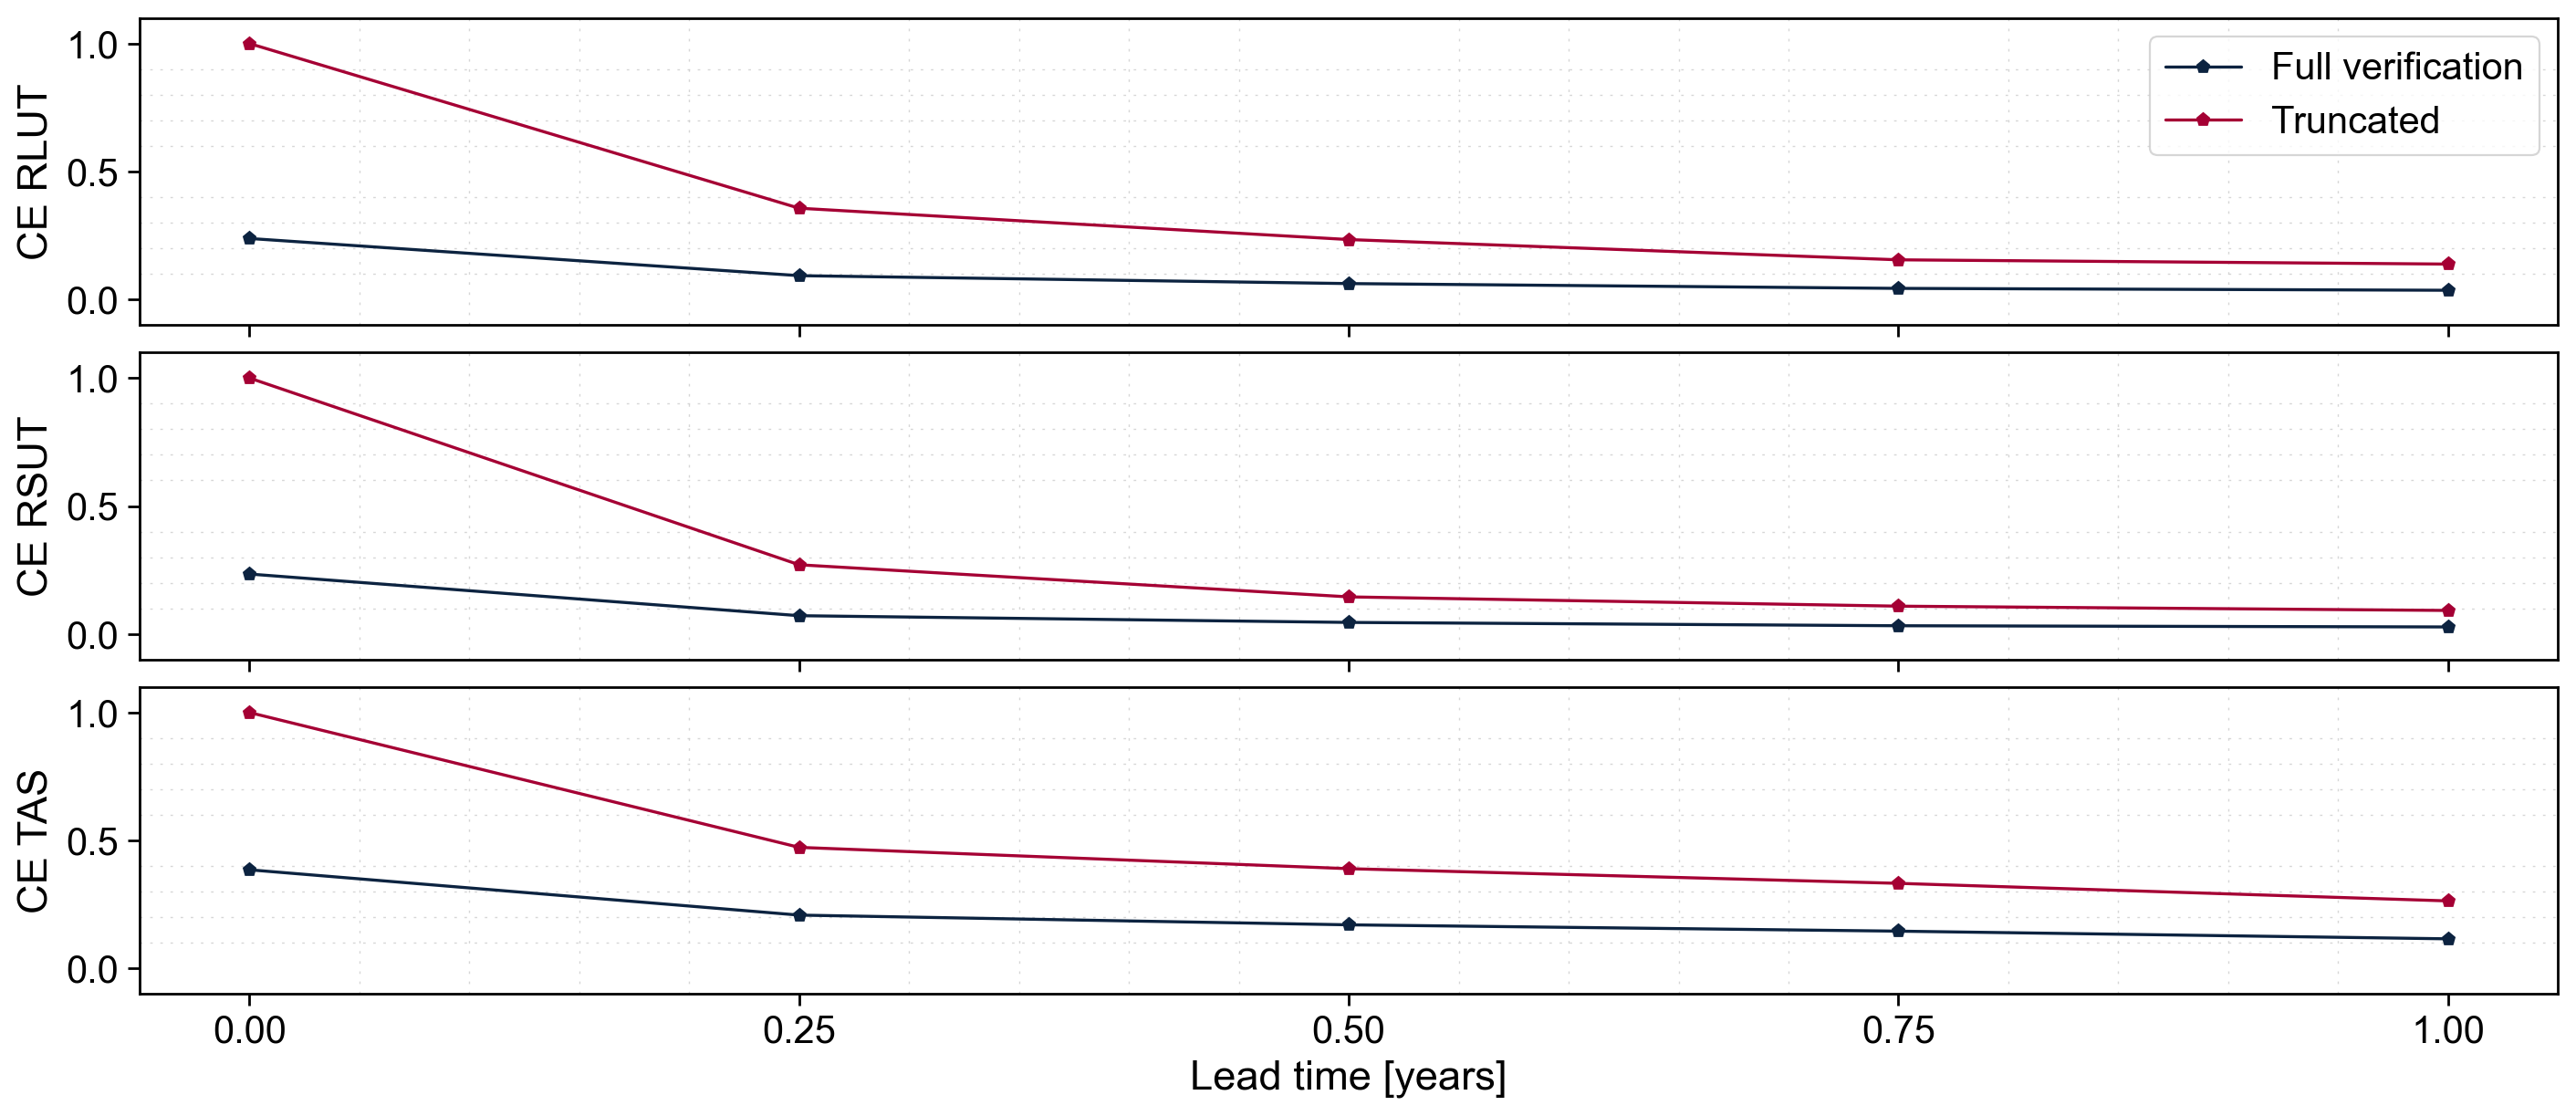

In [ ]:
def plot_forecast_ce_evolution():
    fields = list(ce_full.keys())
    fig, axs = plt.subplots(len(fields), figsize=(14, len(fields) * 2), sharex=True)

    for ax, field in zip(axs, fields):
        ax.plot(ce_full.time, area_weighted_mean(ce_full[field]), "-p", c="C0", label="Full verification")
        ax.plot(ce_trunc.time, area_weighted_mean(ce_trunc[field]), "-p", c="C1", label="Truncated")

    axs[0].legend()
    axs[-1].set_xlabel("Lead time [years]")
    for ax, field in zip(axs, fields):
        ax.set_ylabel(f"CE {field.upper()}")
        ax.set_ylim([-0.1, 1.1])

    format_plot(minor_grid=True, y_minor_locator=mpl.ticker.AutoMinorLocator())
    axs[0].set_xticks(ce_full.time)
    save_plot(plot_folder, "forecast_ce_evolution")

plot_forecast_ce_evolution()

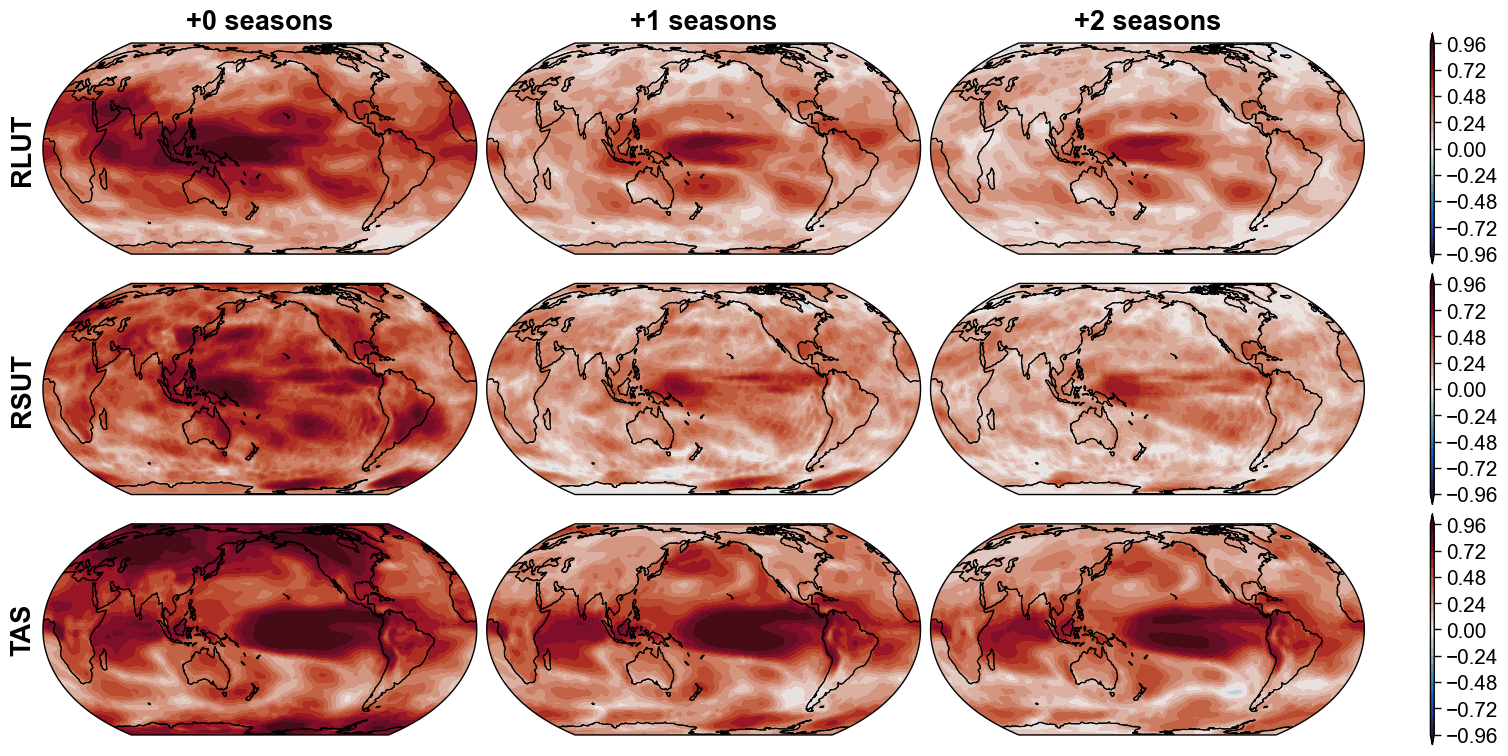

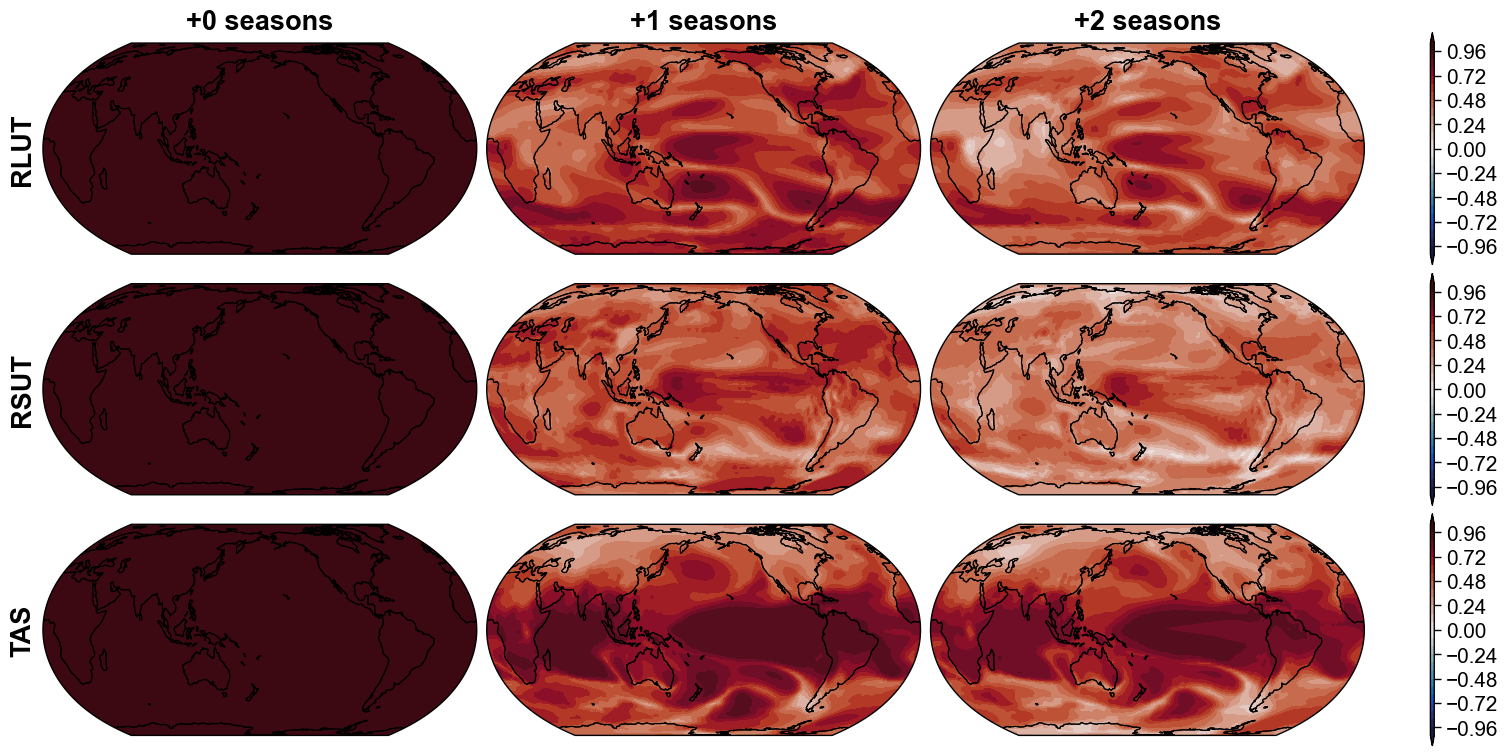

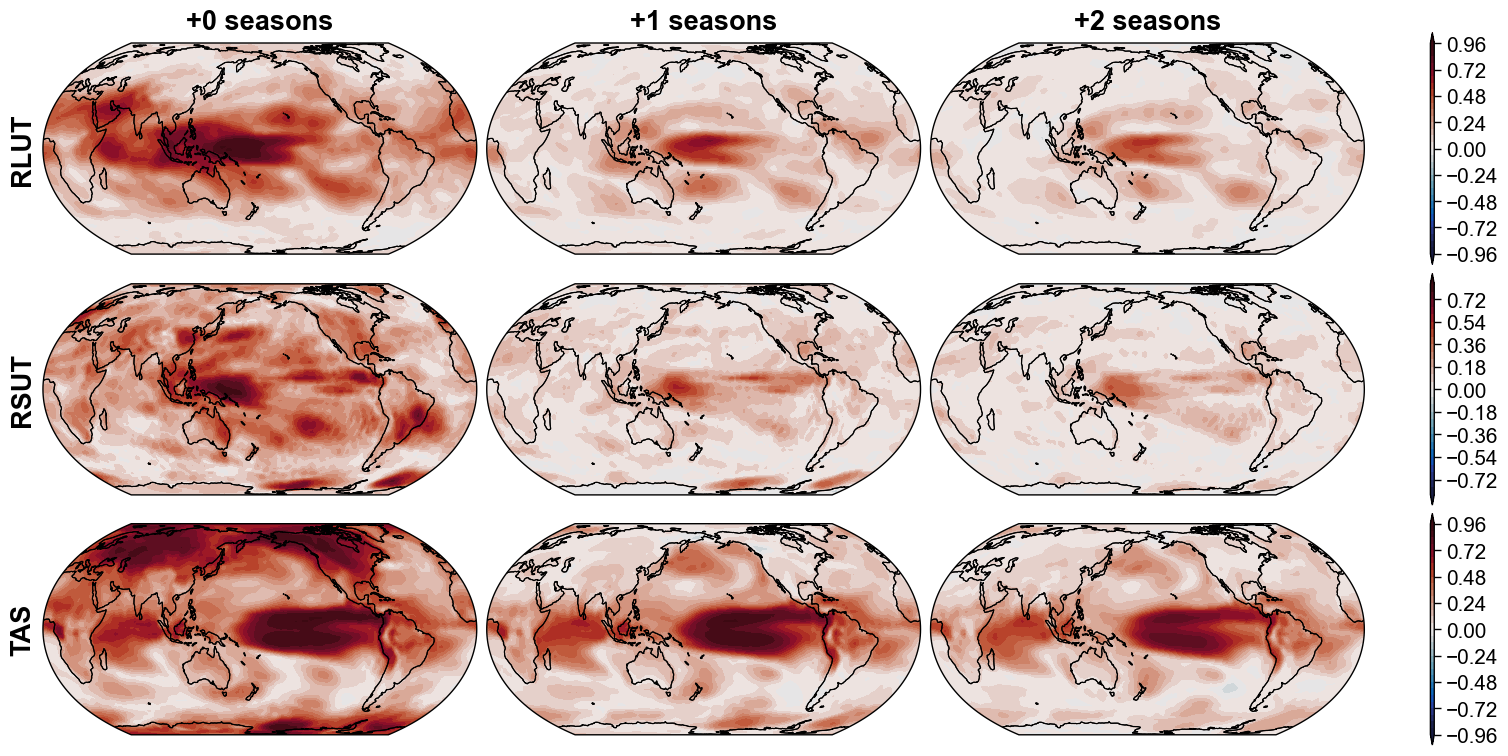

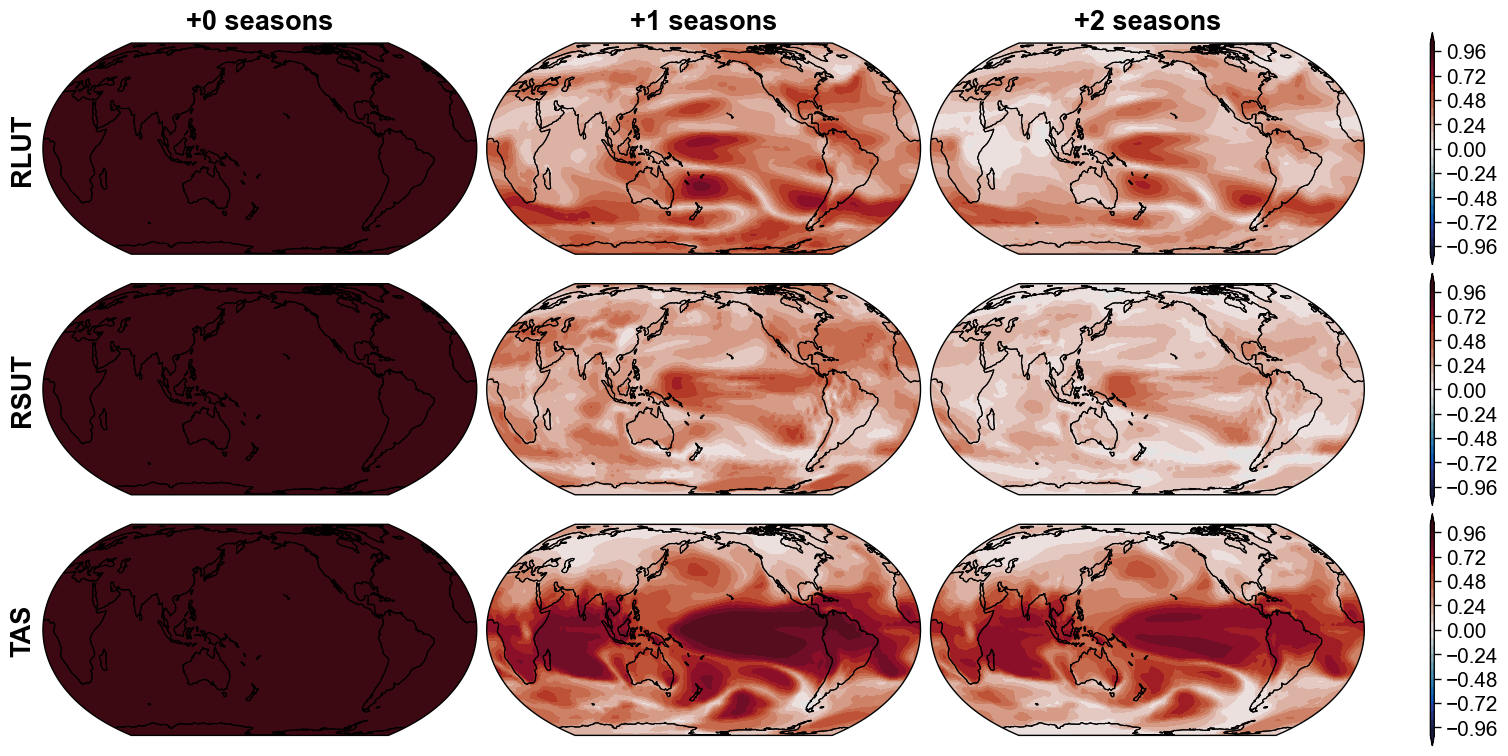

In [ ]:
def plot_forecast_distribution(corr, type, n_steps=3):
    fields = list(corr.keys())
    fig, axs = plt.subplots(
        len(fields),
        n_steps,
        figsize=(5 * (n_steps), 2.5 * len(fields)),
        subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)),
        dpi=100
    )

    for i, field in enumerate(fields):
        axs_row = axs[i]
        for ax in axs_row.flat:
            ax.coastlines()

        plot_field(
            axs_row,
            [corr[field].isel(time=time) for time in range(n_steps)],
            n_level=30,
            cmap=cmocean.cm.balance,
            same_limits=True,
            cbar_orientation="vertical",
        )

    add_subplot_headers(list(map(str.upper, fields)), [f"+{season} seasons" for season in range(n_steps)])

    save_plot(plot_folder, f"forecast_{type}_distribution")

plot_forecast_distribution(corr, "corr")
plot_forecast_distribution(corr_trunc, "corr_trunc")
plot_forecast_distribution(ce_full, "ce")
plot_forecast_distribution(ce_trunc, "ce_trunc")

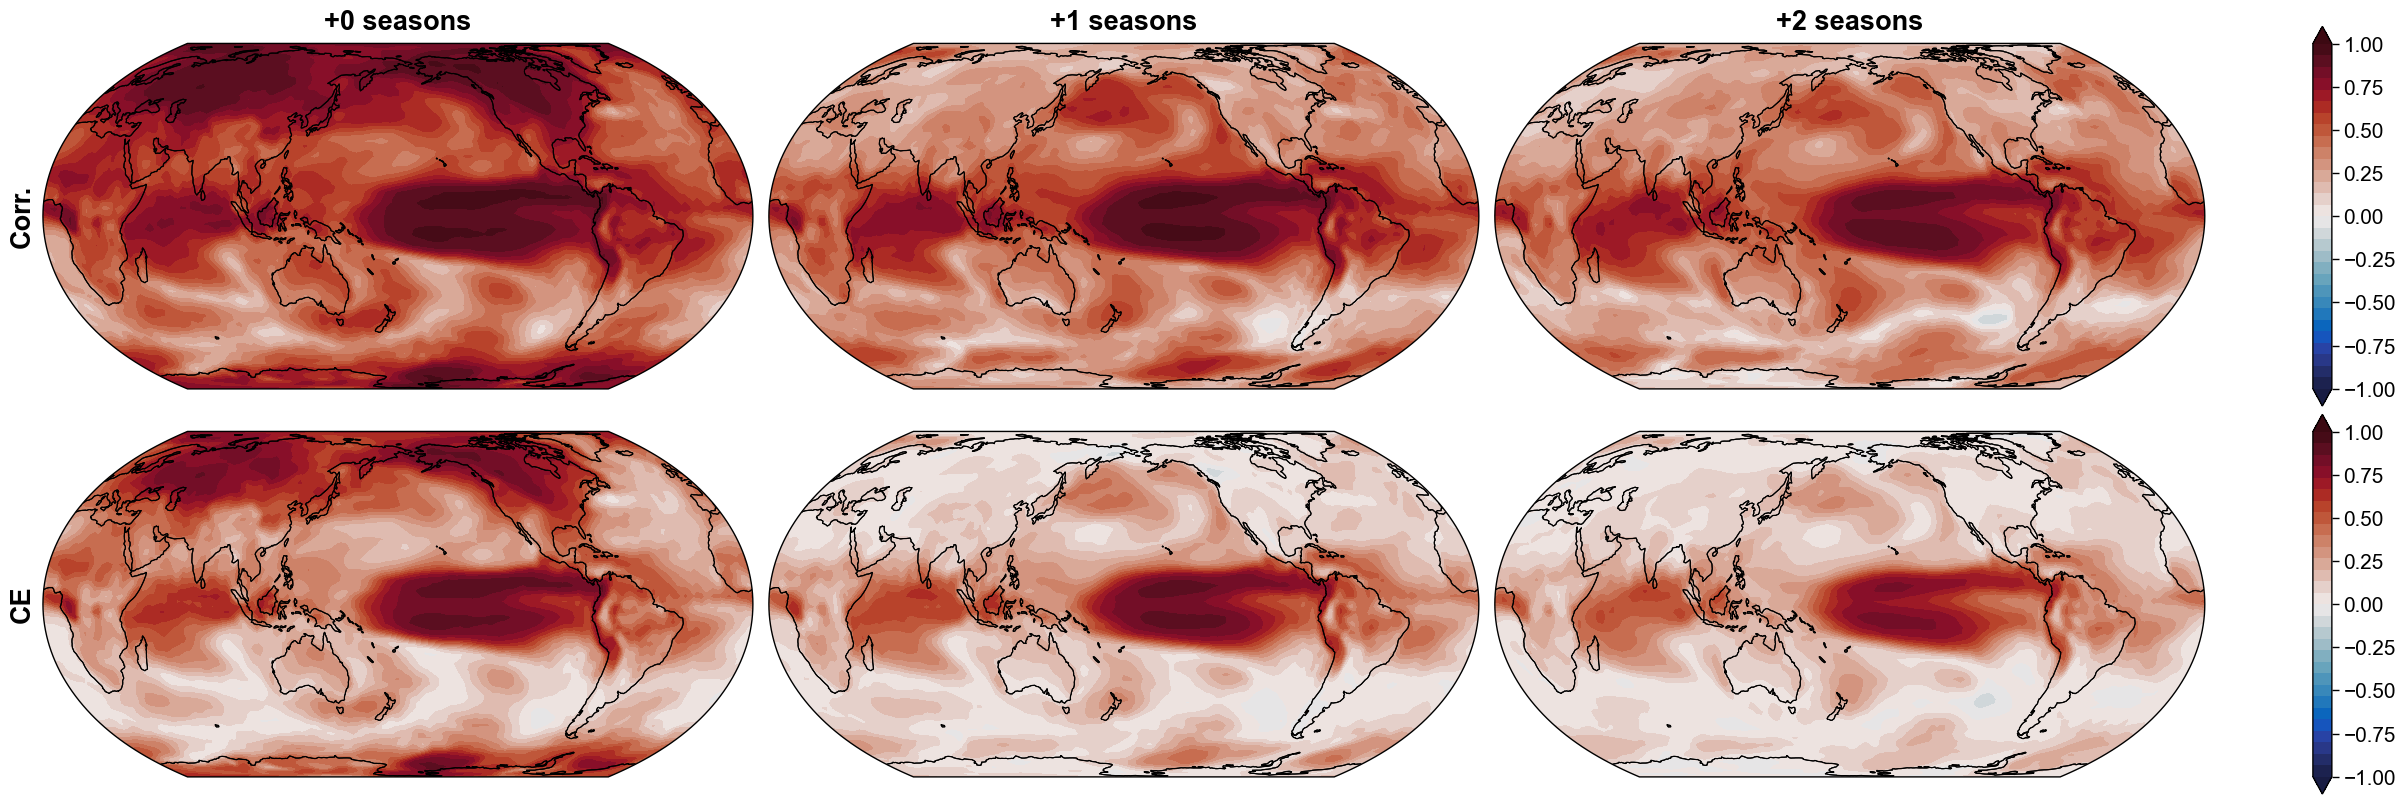

In [ ]:
def plot_forecast_distribution2(corr, ce, field, n_steps=3):
    fig, axs = plt.subplots(
        2,
        n_steps,
        figsize=(8 * (n_steps), 4 * 2),
        subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)),
        dpi=100
    )

    for i, ds in enumerate([corr, ce]):
        axs_row = axs[i]
        for ax in axs_row.flat:
            ax.coastlines()

        plot_field(
            axs_row,
            [ds[field].isel(time=time) for time in range(n_steps)],
            n_level=30,
            cmap=cmocean.cm.balance,
            same_limits=True,
            cbar_orientation="vertical",
            vmin=-1, vmax=1,
            cbar_aspect=20
        )

    add_subplot_headers(["Corr.", "CE"], [f"+{season} seasons" for season in range(n_steps)])

plot_forecast_distribution2(corr, ce_full, "tas")

Deterministic and stochastic forecast have same correlation behavior.

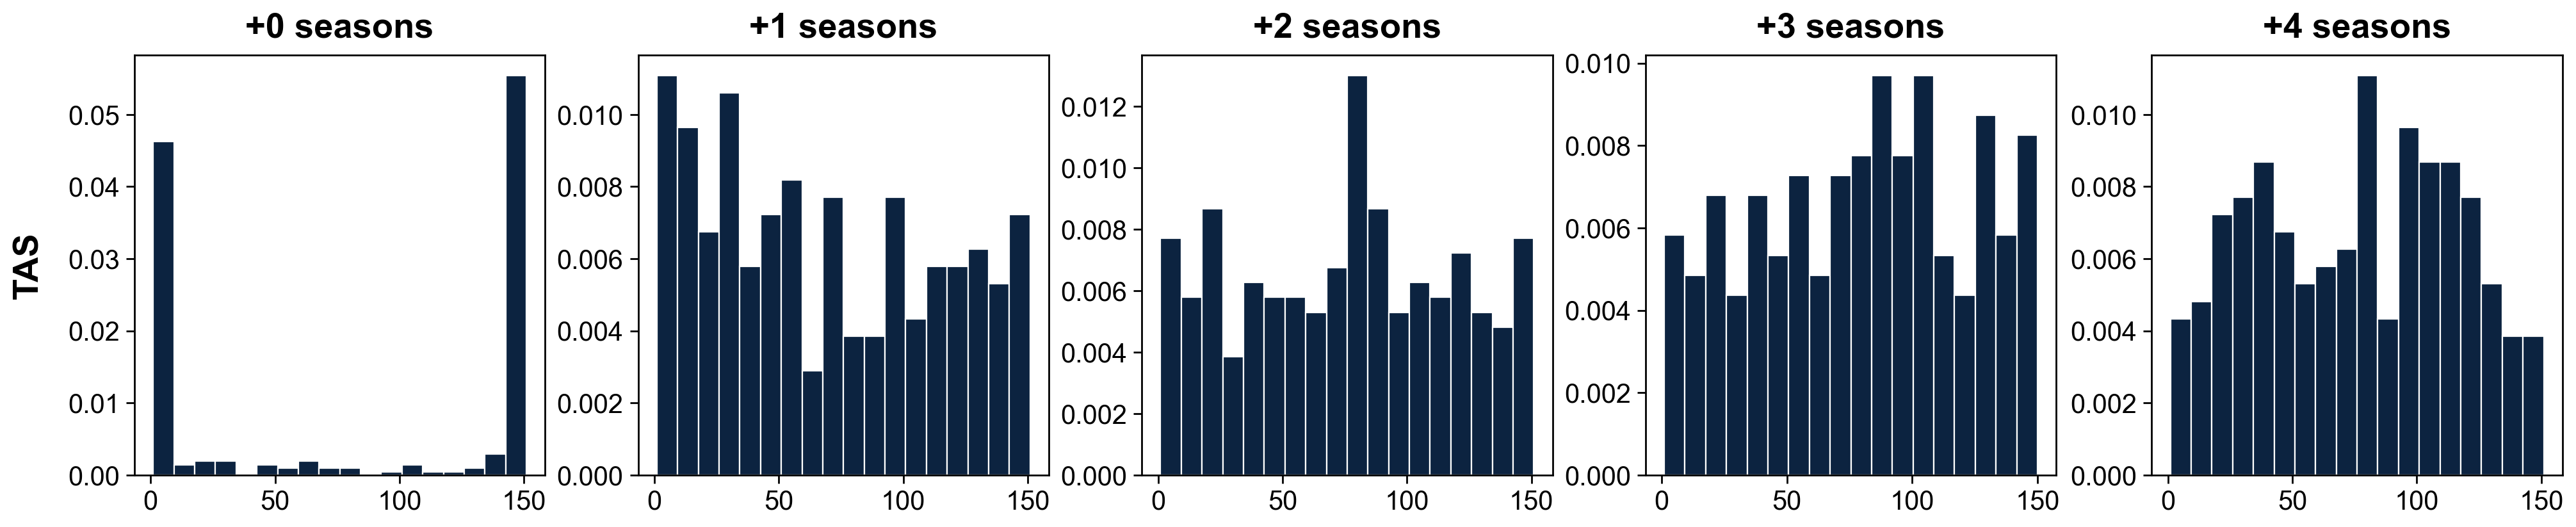

In [ ]:
def plot_rank_histogram(fcs, trues, fields=["tas"]):
    fig, axs = plt.subplots(len(fields), len(fcs.time), figsize=(len(fcs.time) * 4, len(fields) * 4))
    axs = np.atleast_2d(axs)

    # Calculate rank of global means
    fcs = area_weighted_mean(fcs)
    trues = area_weighted_mean(trues)
    n_bins = 1 + len(fcs.ens)

    for i, field in enumerate(fields):
        for j, time in enumerate(fcs.time):
            fcs_time = fcs.sel(time=time)[field]
            trues_time = trues.sel(time=time)[field]
            ranks = scipy.stats.rankdata(np.hstack([trues_time.data[:, np.newaxis], fcs_time.data]), axis=1)[:, 0]
            axs[i, j].hist(ranks, density=True, bins=n_bins // 8)

    add_subplot_headers(list(map(str.upper, fields)), [f"+{step} seasons" for step in range(len(fcs.time.data))])
    save_plot(plot_folder, "forecast_rank_histogram")

plot_rank_histogram(fcs, trues)

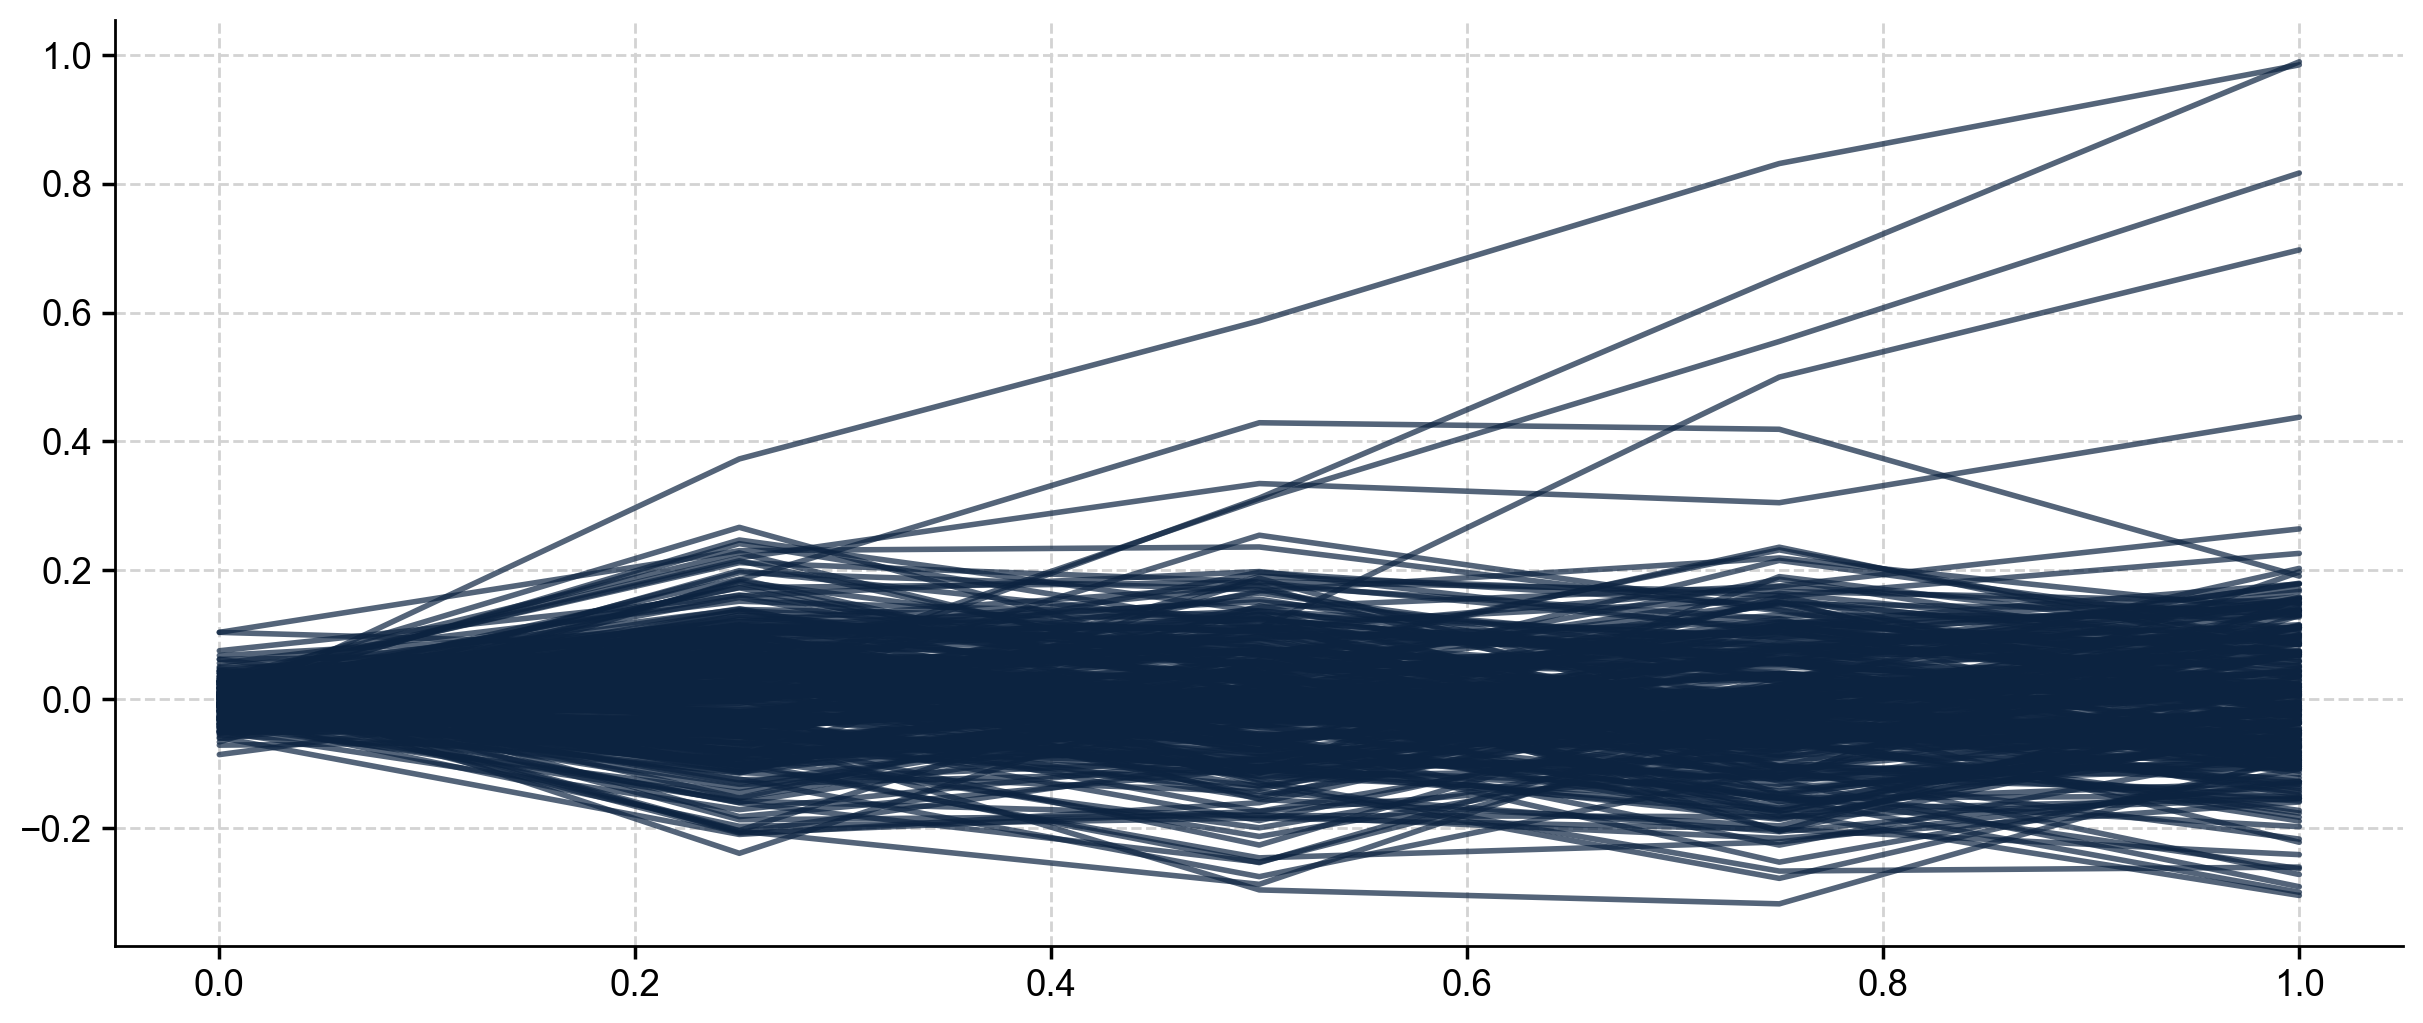

In [ ]:
def plot_forecast_difference(fcs, trues, field="tas"):
    fig, ax = plt.subplots()

    fcs = area_weighted_mean(fcs[field]).mean("ens")
    trues = area_weighted_mean(trues[field])
    diff = fcs - trues

    for i in diff.case:
        ax.plot(diff.time, diff.sel(case=i), color="C0", alpha=0.7)

    ax.legend()

plot_forecast_difference(fcs, trues)

[1.         0.73838373 0.61137634 0.4754815  0.36235602]


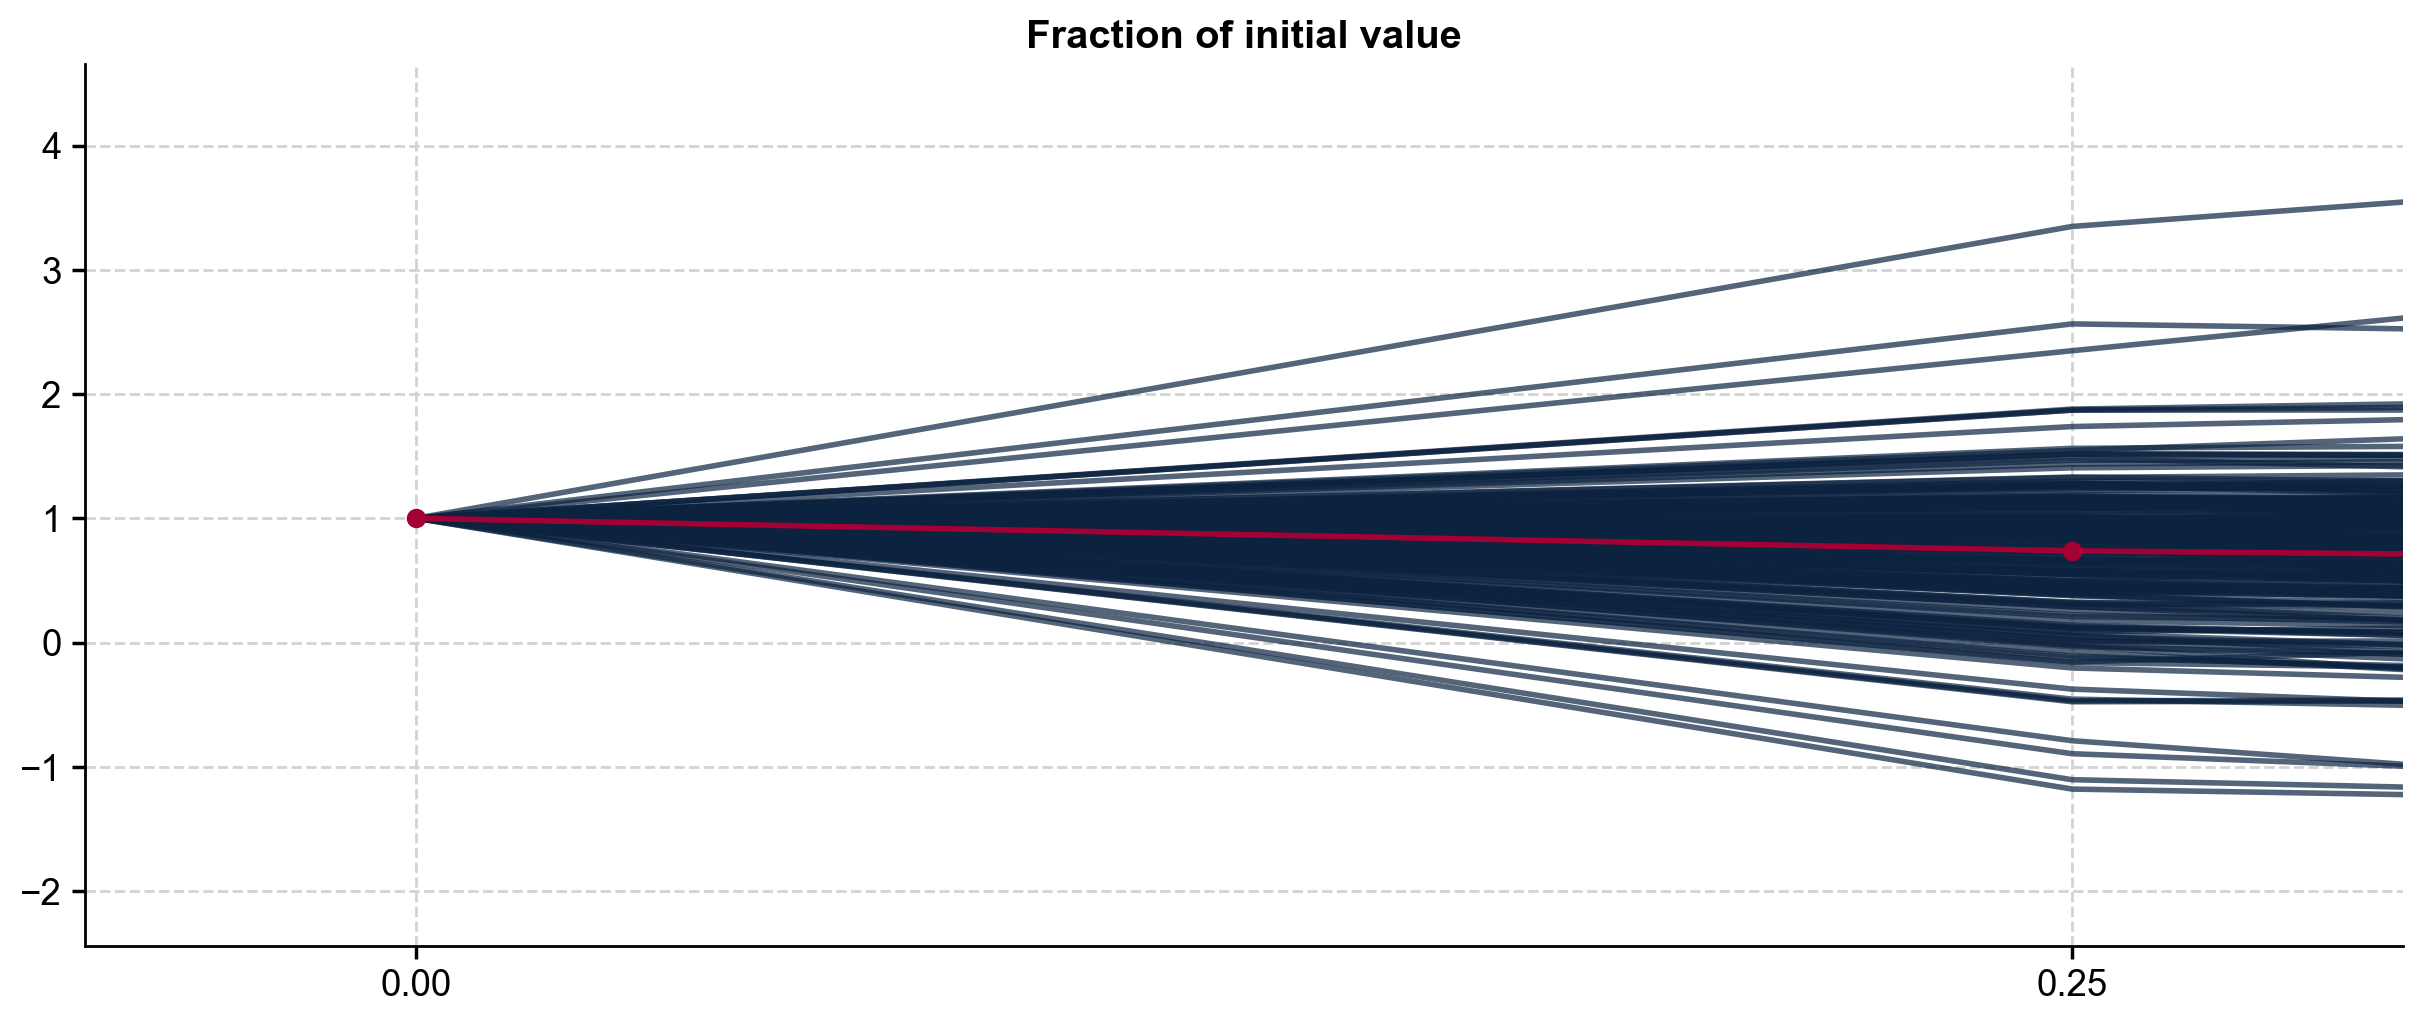

In [ ]:
def plot_forecast_decay(field="tas"):
    fig, ax = plt.subplots()

    fcs_global_mean = area_weighted_mean(fcs_mean[field])#.isel(case=slice(50))
    fcs_global_mean = fcs_global_mean.loc[np.abs(fcs_global_mean.isel(time=0))>0.05]
    decay = fcs_global_mean / fcs_global_mean.isel(time=0)
    for i in decay.case:
        ax.plot(decay.time, decay.sel(case=i), color="C0", alpha=0.7)
    ax.plot(decay.time, decay.mean("case"), color="C1", marker="o")
    print(decay.mean("case").values)

    ax.set_xticks(decay.time)
    ax.set_xlim([-0.05,0.30])
    # ax.set_ylim([-2, 3])
    ax.legend()
    ax.set_title("Fraction of initial value")

plot_forecast_decay()

In [ ]:
def plot_forecast(field="tos", n_steps=9, year=1, mode="anomaly"):
    with logging_disabled():
        initial_reduced = mapper.forward(to_math_order(stack_state(ds_ver.sel(time=year))))
        fc_reduced = lim.forecast_deterministic(initial_reduced, n_steps)
        fc = unstack_state(mapper.backward(fc_reduced))[field]
        
    if mode == "diff":
        true = ds_ver[field].sel(time=slice(year, year + n_steps))
        fc.data = fc.data - true.data

    n_cols = 5
    n_rows = int(ceil((n_steps + 1) / n_cols))
    fig, axs = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 2.5 * n_rows),
        subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=0)),
    )
    for i in range(n_steps + 1, len(axs.flat)):
        axs.flat[i].remove()

    plot_field(
        list(axs.flat),
        [fc.isel(time=i) for i in range(n_steps + 1)],
        n_level=50,
        rotate_cbar_ticks=True,
        cmap="RdBu_r" if mode == "diff" else "Blues",
        same_limits=True,
    )

    for i, ax in enumerate(axs.flat):
        if i >= n_steps + 1:
            break
        ax.set_title(f"+{i} years")
        ax.coastlines()

    save_plot(plot_folder, f"fc_free_{field}_{mode}")


plot_forecast("tas", mode="anomaly")
# plot_forecast("tos", mode="diff")

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

# ECR

In [ ]:
def compute_ecr(fcs, trues):
    fcs = area_weighted_mean(fcs.isel(time=1)).compute()
    trues = area_weighted_mean(trues.isel(time=1)).compute()
    return ((fcs.mean("ens") - trues) ** 2).mean("case") / fcs.var("ens").mean("case")

ecr = compute_ecr(fcs, trues_trunc)
with (plot_folder.parent / "ecr.txt").open("w") as f:
    f.write(str(ecr))
ecr

<xarray.Dataset> Size: 32B
Dimensions:  ()
Coordinates:
    time     float64 8B 0.25
Data variables:
    tas      float64 8B 1.478
    rsut     float64 8B 2.122
    rlut     float64 8B 1.878

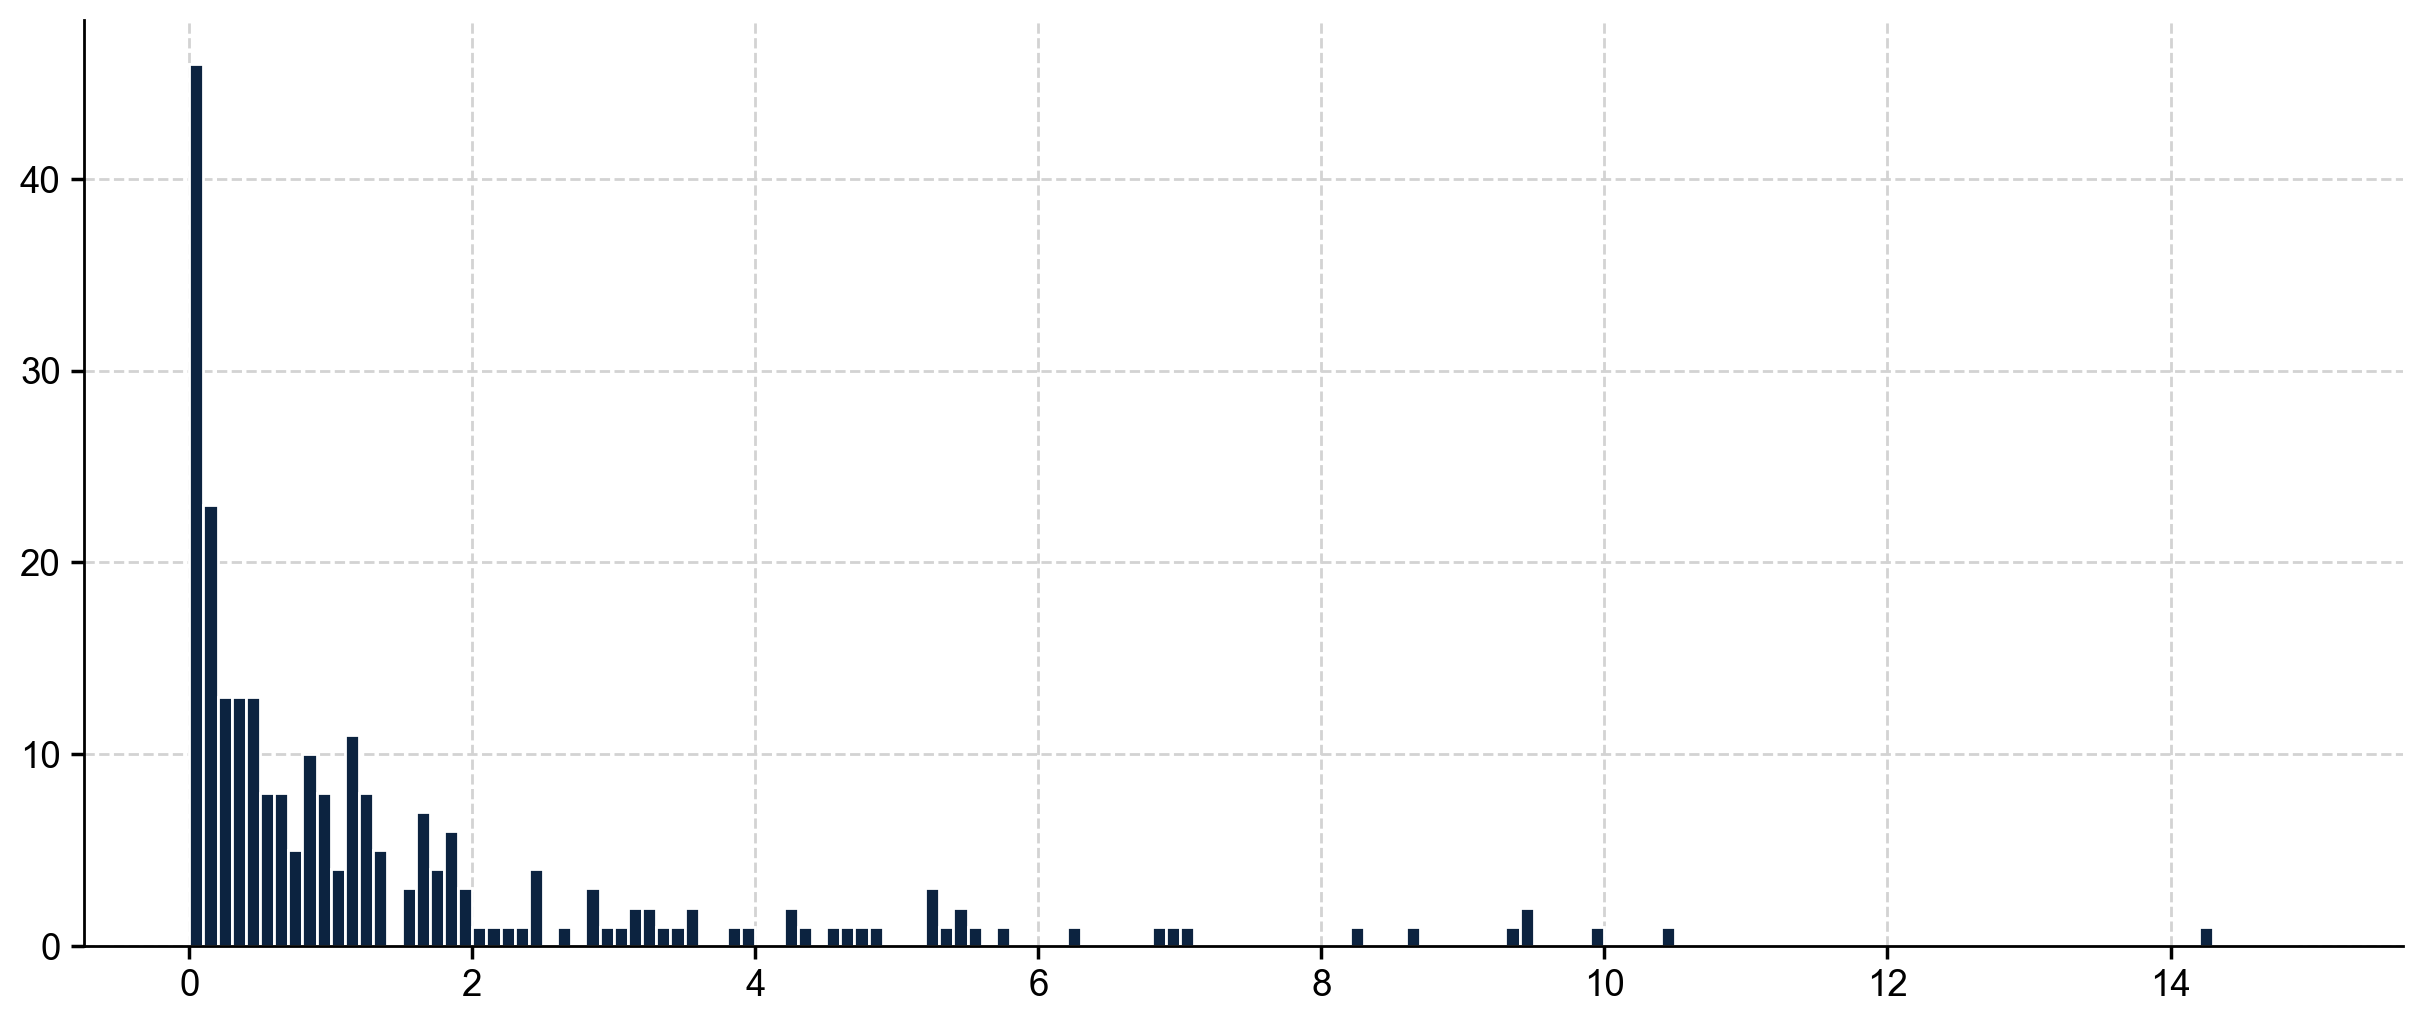

In [ ]:
def plot_ecr(fcs, trues, field="tas"):
    fcs = area_weighted_mean(fcs[field].isel(time=1))
    trues = area_weighted_mean(trues[field].isel(time=1))
    se = ((fcs.mean("ens") - trues) ** 2).compute()
    var = fcs.var("ens").compute()

    fig, ax = plt.subplots()
    # bins = 10
    bins = np.arange(0, 15, 0.1)
    # bins = np.arange(0, 0.1, 0.001)
    # ax.hist(se, bins=bins, color="C0", alpha=0.7, label="Squared error")
    # ax.axvline(se.mean("case"), color="C0")
    # ax.hist(var, bins=bins, color="C1", alpha=0.7, label="Variance")
    # ax.axvline(var.mean("case"), color="C1")
    ax.hist(se/var, bins=bins)
    ax.legend()

plot_ecr(fcs, trues_trunc)

# Radiative feedback

In [38]:
from lmrecon.time import Season


def get_radiation_global_means(n_years=100, n_ens=50):
    ic = to_math_order(
        stack_state(
            create_initial_ensemble_from_sample(
                ds_ver,
                n_ens,
                0,
                Season.DJF,
                0,
            )
        )
    ).compute()
    ic_red = mapper.forward(ic).compute()
    fc_red = lim.forecast_stochastic(ic_red, n_years*4, 1440//4)
    fc = unstack_state(
        mapper.backward(fc_red.chunk(dict(time=50, ens=20)).stack(sample=["ens", "time"])).unstack("sample")
    )[["tas", "eei", "rsut", "rlut"]]
    fc_gm = area_weighted_mean(fc.chunk(dict(time=20, ens=20))).compute()
    return fc_gm

fc_gm = get_radiation_global_means()
fc_gm

2025-03-27 11:10:37    INFO Drawing initial ensemble from years 858.0, 862.0, 870.0, 874.0, 879.0, 918.0, 954.0, 956.0, 963.0, 985.0, 1020.0, 1031.0, 1033.0, 1044.0, 1064.0, 1085.0, 1097.0, 1121.0, 1160.0, 1192.0, 1197.0, 1230.0, 1358.0, 1377.0, 1382.0, 1403.0, 1437.0, 1476.0, 1517.0, 1544.0, 1547.0, 1549.0, 1567.0, 1584.0, 1592.0, 1638.0, 1652.0, 1669.0, 1679.0, 1699.0, 1706.0, 1730.0, 1747.0, 1766.0, 1786.0, 1787.0, 1812.0, 1817.0, 1844.0, 1848.0
2025-03-27 11:10:38    INFO PhysicalSpaceForecastSpaceMapper.forward()
2025-03-27 11:10:38    INFO Splitting dataset into Dask arrays
2025-03-27 11:10:38    INFO Masking nans
2025-03-27 11:10:38    INFO Projecting EOF for tas [1/8]
2025-03-27 11:10:38    INFO Projecting EOF for tos [2/8]
2025-03-27 11:10:38    INFO Projecting EOF for eei [3/8]
2025-03-27 11:10:38    INFO Projecting EOF for rsut [4/8]
2025-03-27 11:10:38    INFO Projecting EOF for rlut [5/8]
2025-03-27 11:10:38    INFO Projecting EOF for ohc300 [6/8]
2025-03-27 11:10:38    IN

<xarray.Dataset> Size: 645kB
Dimensions:  (ens: 50, time: 401)
Coordinates:
  * ens      (ens) int64 400B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * time     (time) float64 3kB 0.04167 0.2917 0.5417 ... 99.54 99.79 100.0
Data variables:
    tas      (ens, time) float64 160kB 0.1058 0.01831 -0.1404 ... 0.1006 0.1531
    eei      (ens, time) float64 160kB -0.6298 0.2615 0.6736 ... 0.5542 0.4444
    rsut     (ens, time) float64 160kB -0.07412 -0.6543 ... -0.5817 -0.9518
    rlut     (ens, time) float64 160kB 0.659 0.4502 0.1955 ... 0.1765 0.5391

In [2]:
def plot_lambda():
    import sklearn
    def get_reg(tas, eei):
        tas = average_annually(tas)
        eei = average_annually(eei)
        tas = tas.transpose(..., "ens").values
        eei = eei.transpose(..., "ens").values
        # return np.array([np.polyfit(tas[:, i], eei[:, i], 1)[0] for i in range(tas.shape[-1])])
        lmbda = []
        for i in range(tas.shape[-1]):
            reg = sklearn.linear_model.RANSACRegressor(random_state=42)
            reg.fit(tas[:, [i]], eei[:, [i]])
            lmbda.append(np.squeeze(reg.estimator_.coef_))
        return lmbda

    lambda_reg = []
    for type in ["eei", "eei_inferred", "rlut", "rsut"]:
        tas = fc_gm["tas"]
        match type:
            case "eei": eei = fc_gm["eei"]
            case "eei_inferred": eei = - (fc_gm["rsut"] + fc_gm["rlut"])
            case "rsut": eei = -fc_gm["rsut"]
            case "rlut": eei = -fc_gm["rlut"]
        
        lambda_reg.append(get_reg(tas, eei))
    
    da = xr.DataArray(np.array(lambda_reg), dims=["type", "ens"])
    da = da.assign_coords(type=[r"$\lambda_{EEI}$", "EEI inferred", "RLUT", "RSUT"]).expand_dims("method").assign_coords(method=["Annual regression"])
    df = da.to_dataframe(name="lambda").reset_index()

    import seaborn as sns
    fig, ax = plt.subplots()
    sns.boxplot(data=df, x="type", y="lambda", hue="method", orient="v", width=0.4, ax=ax)
    ax.set_ylim(-4, 7)
    ax.set_title("$\lambda$ from LIM")
    ax.axhline(0, ls=":")

plot_lambda()

<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
/var/folders/3d/4bftgf1973q9f2hmg4gztmpw0000gn/T/ipykernel_29035/4241101574.py:35: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title("$\lambda$ from LIM")
/var/folders/3d/4bftgf1973q9f2hmg4gztmpw0000gn/T/ipykernel_29035/4241101574.py:35: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title("$\lambda$ from LIM")


NameError: name 'fc_gm' is not defined